In [1]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [2]:
model_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_8/models/epoch_26.pt'
dataset_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_8/data/test_data.file'

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_8/models/epoch_26.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [3]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [4]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

# Fit GMM and calculate indices

In [5]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(5, 40))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

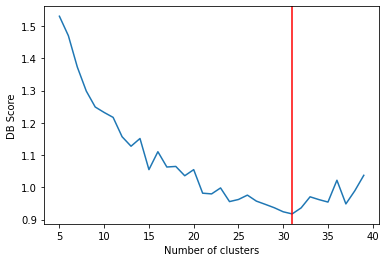

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}


In [6]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

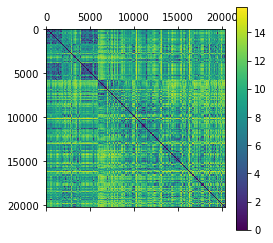

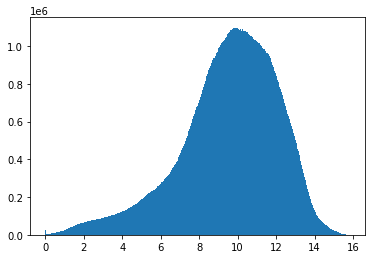

In [7]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

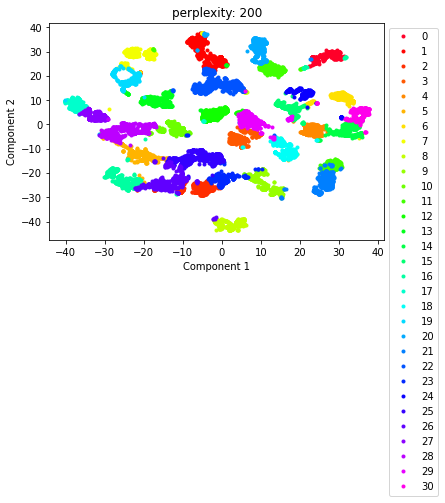

In [8]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [9]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [10]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [11]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [12]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 8

In [13]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.9543192233775193


In [14]:
losses = []
accs = []
sparsity = []

In [15]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.6554219477846388
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.988950276243094
layer 5: 0.8344267955801105
layer 6: 0.6953556629834255
Epoch: 00 | Batch: 000 / 011 | Total loss: 3.439 | Reg loss: 0.016 | Tree loss: 3.439 | Accuracy: 0.058500 | 0.424 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 3.433 | Reg loss: 0.016 | Tree loss: 3.433 | Accuracy: 0.049000 | 0.355 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 3.426 | Reg loss: 0.016 | Tree loss: 3.426 | Accuracy: 0.059500 | 0.333 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 3.422 | Reg loss: 0.016 | Tree loss: 3.422 | Accuracy: 0.045500 | 0.32 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 3.418 | Reg loss: 0.016 | Tree loss: 3.418 | Accuracy: 0.063500 | 0.303 sec/iter
Epoch: 00 | Batch: 005 / 011 | Total loss: 3.416 | Reg loss: 0.016 | Tree loss: 3.416 | Accuracy: 0.080500 | 0.298 sec/iter
Epoch: 00 | Batch: 006 / 01

Epoch: 05 | Batch: 000 / 011 | Total loss: 3.360 | Reg loss: 0.016 | Tree loss: 3.360 | Accuracy: 0.214500 | 0.292 sec/iter
Epoch: 05 | Batch: 001 / 011 | Total loss: 3.347 | Reg loss: 0.016 | Tree loss: 3.347 | Accuracy: 0.250000 | 0.291 sec/iter
Epoch: 05 | Batch: 002 / 011 | Total loss: 3.328 | Reg loss: 0.016 | Tree loss: 3.328 | Accuracy: 0.219000 | 0.29 sec/iter
Epoch: 05 | Batch: 003 / 011 | Total loss: 3.304 | Reg loss: 0.016 | Tree loss: 3.304 | Accuracy: 0.211000 | 0.289 sec/iter
Epoch: 05 | Batch: 004 / 011 | Total loss: 3.287 | Reg loss: 0.016 | Tree loss: 3.287 | Accuracy: 0.203000 | 0.288 sec/iter
Epoch: 05 | Batch: 005 / 011 | Total loss: 3.270 | Reg loss: 0.016 | Tree loss: 3.270 | Accuracy: 0.186000 | 0.287 sec/iter
Epoch: 05 | Batch: 006 / 011 | Total loss: 3.253 | Reg loss: 0.017 | Tree loss: 3.253 | Accuracy: 0.179500 | 0.286 sec/iter
Epoch: 05 | Batch: 007 / 011 | Total loss: 3.234 | Reg loss: 0.017 | Tree loss: 3.234 | Accuracy: 0.169000 | 0.285 sec/iter
Epoch: 05

Epoch: 10 | Batch: 002 / 011 | Total loss: 3.159 | Reg loss: 0.019 | Tree loss: 3.159 | Accuracy: 0.269500 | 0.277 sec/iter
Epoch: 10 | Batch: 003 / 011 | Total loss: 3.123 | Reg loss: 0.019 | Tree loss: 3.123 | Accuracy: 0.261000 | 0.277 sec/iter
Epoch: 10 | Batch: 004 / 011 | Total loss: 3.085 | Reg loss: 0.020 | Tree loss: 3.085 | Accuracy: 0.244500 | 0.277 sec/iter
Epoch: 10 | Batch: 005 / 011 | Total loss: 3.051 | Reg loss: 0.020 | Tree loss: 3.051 | Accuracy: 0.250000 | 0.276 sec/iter
Epoch: 10 | Batch: 006 / 011 | Total loss: 3.019 | Reg loss: 0.020 | Tree loss: 3.019 | Accuracy: 0.246500 | 0.276 sec/iter
Epoch: 10 | Batch: 007 / 011 | Total loss: 3.001 | Reg loss: 0.020 | Tree loss: 3.001 | Accuracy: 0.237000 | 0.276 sec/iter
Epoch: 10 | Batch: 008 / 011 | Total loss: 2.988 | Reg loss: 0.021 | Tree loss: 2.988 | Accuracy: 0.234000 | 0.275 sec/iter
Epoch: 10 | Batch: 009 / 011 | Total loss: 2.966 | Reg loss: 0.021 | Tree loss: 2.966 | Accuracy: 0.237000 | 0.275 sec/iter
Epoch: 1

Epoch: 15 | Batch: 004 / 011 | Total loss: 2.807 | Reg loss: 0.023 | Tree loss: 2.807 | Accuracy: 0.295500 | 0.271 sec/iter
Epoch: 15 | Batch: 005 / 011 | Total loss: 2.774 | Reg loss: 0.023 | Tree loss: 2.774 | Accuracy: 0.294500 | 0.271 sec/iter
Epoch: 15 | Batch: 006 / 011 | Total loss: 2.749 | Reg loss: 0.023 | Tree loss: 2.749 | Accuracy: 0.289000 | 0.271 sec/iter
Epoch: 15 | Batch: 007 / 011 | Total loss: 2.721 | Reg loss: 0.023 | Tree loss: 2.721 | Accuracy: 0.310500 | 0.27 sec/iter
Epoch: 15 | Batch: 008 / 011 | Total loss: 2.716 | Reg loss: 0.024 | Tree loss: 2.716 | Accuracy: 0.286500 | 0.27 sec/iter
Epoch: 15 | Batch: 009 / 011 | Total loss: 2.695 | Reg loss: 0.024 | Tree loss: 2.695 | Accuracy: 0.303000 | 0.27 sec/iter
Epoch: 15 | Batch: 010 / 011 | Total loss: 2.709 | Reg loss: 0.024 | Tree loss: 2.709 | Accuracy: 0.249147 | 0.27 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.97

Epoch: 20 | Batch: 006 / 011 | Total loss: 2.531 | Reg loss: 0.025 | Tree loss: 2.531 | Accuracy: 0.292000 | 0.271 sec/iter
Epoch: 20 | Batch: 007 / 011 | Total loss: 2.522 | Reg loss: 0.025 | Tree loss: 2.522 | Accuracy: 0.281000 | 0.271 sec/iter
Epoch: 20 | Batch: 008 / 011 | Total loss: 2.516 | Reg loss: 0.025 | Tree loss: 2.516 | Accuracy: 0.286000 | 0.271 sec/iter
Epoch: 20 | Batch: 009 / 011 | Total loss: 2.518 | Reg loss: 0.025 | Tree loss: 2.518 | Accuracy: 0.276000 | 0.271 sec/iter
Epoch: 20 | Batch: 010 / 011 | Total loss: 2.466 | Reg loss: 0.025 | Tree loss: 2.466 | Accuracy: 0.273038 | 0.271 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 21 | Batch: 000 / 011 | Total loss: 2.767 | Reg loss: 0.025 | Tree loss: 2.767 | Accuracy: 0.273500 | 0.272 sec/iter
Epoch: 21 | Batch: 00

Epoch: 25 | Batch: 008 / 011 | Total loss: 2.357 | Reg loss: 0.026 | Tree loss: 2.357 | Accuracy: 0.273500 | 0.27 sec/iter
Epoch: 25 | Batch: 009 / 011 | Total loss: 2.364 | Reg loss: 0.026 | Tree loss: 2.364 | Accuracy: 0.270000 | 0.27 sec/iter
Epoch: 25 | Batch: 010 / 011 | Total loss: 2.357 | Reg loss: 0.026 | Tree loss: 2.357 | Accuracy: 0.313993 | 0.27 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 26 | Batch: 000 / 011 | Total loss: 2.601 | Reg loss: 0.026 | Tree loss: 2.601 | Accuracy: 0.288000 | 0.27 sec/iter
Epoch: 26 | Batch: 001 / 011 | Total loss: 2.539 | Reg loss: 0.026 | Tree loss: 2.539 | Accuracy: 0.279000 | 0.27 sec/iter
Epoch: 26 | Batch: 002 / 011 | Total loss: 2.479 | Reg loss: 0.026 | Tree loss: 2.479 | Accuracy: 0.302500 | 0.27 sec/iter
Epoch: 26 | Batch: 003 / 01

Epoch: 30 | Batch: 010 / 011 | Total loss: 2.261 | Reg loss: 0.027 | Tree loss: 2.261 | Accuracy: 0.249147 | 0.27 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 31 | Batch: 000 / 011 | Total loss: 2.443 | Reg loss: 0.027 | Tree loss: 2.443 | Accuracy: 0.313500 | 0.271 sec/iter
Epoch: 31 | Batch: 001 / 011 | Total loss: 2.423 | Reg loss: 0.027 | Tree loss: 2.423 | Accuracy: 0.309000 | 0.271 sec/iter
Epoch: 31 | Batch: 002 / 011 | Total loss: 2.361 | Reg loss: 0.027 | Tree loss: 2.361 | Accuracy: 0.326000 | 0.27 sec/iter
Epoch: 31 | Batch: 003 / 011 | Total loss: 2.333 | Reg loss: 0.027 | Tree loss: 2.333 | Accuracy: 0.318500 | 0.27 sec/iter
Epoch: 31 | Batch: 004 / 011 | Total loss: 2.294 | Reg loss: 0.027 | Tree loss: 2.294 | Accuracy: 0.324500 | 0.271 sec/iter
Epoch: 31 | Batch: 005 /

Epoch: 36 | Batch: 000 / 011 | Total loss: 2.342 | Reg loss: 0.027 | Tree loss: 2.342 | Accuracy: 0.338500 | 0.27 sec/iter
Epoch: 36 | Batch: 001 / 011 | Total loss: 2.311 | Reg loss: 0.027 | Tree loss: 2.311 | Accuracy: 0.332000 | 0.27 sec/iter
Epoch: 36 | Batch: 002 / 011 | Total loss: 2.295 | Reg loss: 0.027 | Tree loss: 2.295 | Accuracy: 0.317000 | 0.27 sec/iter
Epoch: 36 | Batch: 003 / 011 | Total loss: 2.232 | Reg loss: 0.027 | Tree loss: 2.232 | Accuracy: 0.336000 | 0.27 sec/iter
Epoch: 36 | Batch: 004 / 011 | Total loss: 2.211 | Reg loss: 0.027 | Tree loss: 2.211 | Accuracy: 0.325000 | 0.27 sec/iter
Epoch: 36 | Batch: 005 / 011 | Total loss: 2.190 | Reg loss: 0.027 | Tree loss: 2.190 | Accuracy: 0.311000 | 0.27 sec/iter
Epoch: 36 | Batch: 006 / 011 | Total loss: 2.171 | Reg loss: 0.027 | Tree loss: 2.171 | Accuracy: 0.315500 | 0.27 sec/iter
Epoch: 36 | Batch: 007 / 011 | Total loss: 2.154 | Reg loss: 0.027 | Tree loss: 2.154 | Accuracy: 0.302000 | 0.269 sec/iter
Epoch: 36 | Bat

Epoch: 41 | Batch: 002 / 011 | Total loss: 2.195 | Reg loss: 0.028 | Tree loss: 2.195 | Accuracy: 0.329000 | 0.268 sec/iter
Epoch: 41 | Batch: 003 / 011 | Total loss: 2.180 | Reg loss: 0.028 | Tree loss: 2.180 | Accuracy: 0.324000 | 0.268 sec/iter
Epoch: 41 | Batch: 004 / 011 | Total loss: 2.158 | Reg loss: 0.028 | Tree loss: 2.158 | Accuracy: 0.317000 | 0.268 sec/iter
Epoch: 41 | Batch: 005 / 011 | Total loss: 2.117 | Reg loss: 0.028 | Tree loss: 2.117 | Accuracy: 0.331500 | 0.268 sec/iter
Epoch: 41 | Batch: 006 / 011 | Total loss: 2.102 | Reg loss: 0.028 | Tree loss: 2.102 | Accuracy: 0.323500 | 0.268 sec/iter
Epoch: 41 | Batch: 007 / 011 | Total loss: 2.081 | Reg loss: 0.028 | Tree loss: 2.081 | Accuracy: 0.334500 | 0.268 sec/iter
Epoch: 41 | Batch: 008 / 011 | Total loss: 2.080 | Reg loss: 0.028 | Tree loss: 2.080 | Accuracy: 0.337500 | 0.268 sec/iter
Epoch: 41 | Batch: 009 / 011 | Total loss: 2.064 | Reg loss: 0.028 | Tree loss: 2.064 | Accuracy: 0.320500 | 0.268 sec/iter
Epoch: 4

Epoch: 46 | Batch: 004 / 011 | Total loss: 2.093 | Reg loss: 0.029 | Tree loss: 2.093 | Accuracy: 0.336000 | 0.268 sec/iter
Epoch: 46 | Batch: 005 / 011 | Total loss: 2.074 | Reg loss: 0.029 | Tree loss: 2.074 | Accuracy: 0.309000 | 0.268 sec/iter
Epoch: 46 | Batch: 006 / 011 | Total loss: 2.043 | Reg loss: 0.029 | Tree loss: 2.043 | Accuracy: 0.328000 | 0.268 sec/iter
Epoch: 46 | Batch: 007 / 011 | Total loss: 2.021 | Reg loss: 0.029 | Tree loss: 2.021 | Accuracy: 0.337000 | 0.267 sec/iter
Epoch: 46 | Batch: 008 / 011 | Total loss: 2.004 | Reg loss: 0.029 | Tree loss: 2.004 | Accuracy: 0.334000 | 0.267 sec/iter
Epoch: 46 | Batch: 009 / 011 | Total loss: 2.006 | Reg loss: 0.029 | Tree loss: 2.006 | Accuracy: 0.350500 | 0.268 sec/iter
Epoch: 46 | Batch: 010 / 011 | Total loss: 2.036 | Reg loss: 0.029 | Tree loss: 2.036 | Accuracy: 0.317406 | 0.267 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 

Epoch: 51 | Batch: 006 / 011 | Total loss: 1.997 | Reg loss: 0.029 | Tree loss: 1.997 | Accuracy: 0.344000 | 0.267 sec/iter
Epoch: 51 | Batch: 007 / 011 | Total loss: 1.986 | Reg loss: 0.029 | Tree loss: 1.986 | Accuracy: 0.342500 | 0.267 sec/iter
Epoch: 51 | Batch: 008 / 011 | Total loss: 1.971 | Reg loss: 0.029 | Tree loss: 1.971 | Accuracy: 0.328000 | 0.267 sec/iter
Epoch: 51 | Batch: 009 / 011 | Total loss: 1.969 | Reg loss: 0.029 | Tree loss: 1.969 | Accuracy: 0.326000 | 0.267 sec/iter
Epoch: 51 | Batch: 010 / 011 | Total loss: 1.999 | Reg loss: 0.029 | Tree loss: 1.999 | Accuracy: 0.341297 | 0.267 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 52 | Batch: 000 / 011 | Total loss: 2.163 | Reg loss: 0.029 | Tree loss: 2.163 | Accuracy: 0.353000 | 0.267 sec/iter
Epoch: 52 | Batch: 00

Epoch: 56 | Batch: 008 / 011 | Total loss: 1.971 | Reg loss: 0.030 | Tree loss: 1.971 | Accuracy: 0.324000 | 0.266 sec/iter
Epoch: 56 | Batch: 009 / 011 | Total loss: 1.939 | Reg loss: 0.030 | Tree loss: 1.939 | Accuracy: 0.336500 | 0.266 sec/iter
Epoch: 56 | Batch: 010 / 011 | Total loss: 1.936 | Reg loss: 0.030 | Tree loss: 1.936 | Accuracy: 0.327645 | 0.266 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 57 | Batch: 000 / 011 | Total loss: 2.121 | Reg loss: 0.030 | Tree loss: 2.121 | Accuracy: 0.347000 | 0.266 sec/iter
Epoch: 57 | Batch: 001 / 011 | Total loss: 2.065 | Reg loss: 0.030 | Tree loss: 2.065 | Accuracy: 0.360000 | 0.266 sec/iter
Epoch: 57 | Batch: 002 / 011 | Total loss: 2.067 | Reg loss: 0.030 | Tree loss: 2.067 | Accuracy: 0.339500 | 0.266 sec/iter
Epoch: 57 | Batch: 00

Epoch: 61 | Batch: 010 / 011 | Total loss: 1.950 | Reg loss: 0.030 | Tree loss: 1.950 | Accuracy: 0.334471 | 0.266 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 62 | Batch: 000 / 011 | Total loss: 2.089 | Reg loss: 0.030 | Tree loss: 2.089 | Accuracy: 0.346500 | 0.266 sec/iter
Epoch: 62 | Batch: 001 / 011 | Total loss: 2.053 | Reg loss: 0.030 | Tree loss: 2.053 | Accuracy: 0.352500 | 0.266 sec/iter
Epoch: 62 | Batch: 002 / 011 | Total loss: 2.021 | Reg loss: 0.030 | Tree loss: 2.021 | Accuracy: 0.358000 | 0.266 sec/iter
Epoch: 62 | Batch: 003 / 011 | Total loss: 1.979 | Reg loss: 0.030 | Tree loss: 1.979 | Accuracy: 0.375000 | 0.266 sec/iter
Epoch: 62 | Batch: 004 / 011 | Total loss: 1.962 | Reg loss: 0.030 | Tree loss: 1.962 | Accuracy: 0.372500 | 0.266 sec/iter
Epoch: 62 | Batch: 00

Epoch: 67 | Batch: 000 / 011 | Total loss: 2.055 | Reg loss: 0.030 | Tree loss: 2.055 | Accuracy: 0.352500 | 0.266 sec/iter
Epoch: 67 | Batch: 001 / 011 | Total loss: 2.035 | Reg loss: 0.031 | Tree loss: 2.035 | Accuracy: 0.347000 | 0.266 sec/iter
Epoch: 67 | Batch: 002 / 011 | Total loss: 1.991 | Reg loss: 0.031 | Tree loss: 1.991 | Accuracy: 0.348500 | 0.265 sec/iter
Epoch: 67 | Batch: 003 / 011 | Total loss: 1.951 | Reg loss: 0.031 | Tree loss: 1.951 | Accuracy: 0.363500 | 0.265 sec/iter
Epoch: 67 | Batch: 004 / 011 | Total loss: 1.925 | Reg loss: 0.031 | Tree loss: 1.925 | Accuracy: 0.366000 | 0.265 sec/iter
Epoch: 67 | Batch: 005 / 011 | Total loss: 1.917 | Reg loss: 0.031 | Tree loss: 1.917 | Accuracy: 0.357000 | 0.265 sec/iter
Epoch: 67 | Batch: 006 / 011 | Total loss: 1.880 | Reg loss: 0.031 | Tree loss: 1.880 | Accuracy: 0.377500 | 0.265 sec/iter
Epoch: 67 | Batch: 007 / 011 | Total loss: 1.892 | Reg loss: 0.031 | Tree loss: 1.892 | Accuracy: 0.374000 | 0.265 sec/iter
Epoch: 6

Epoch: 72 | Batch: 002 / 011 | Total loss: 1.961 | Reg loss: 0.031 | Tree loss: 1.961 | Accuracy: 0.356500 | 0.264 sec/iter
Epoch: 72 | Batch: 003 / 011 | Total loss: 1.912 | Reg loss: 0.031 | Tree loss: 1.912 | Accuracy: 0.379500 | 0.264 sec/iter
Epoch: 72 | Batch: 004 / 011 | Total loss: 1.935 | Reg loss: 0.031 | Tree loss: 1.935 | Accuracy: 0.358500 | 0.264 sec/iter
Epoch: 72 | Batch: 005 / 011 | Total loss: 1.890 | Reg loss: 0.031 | Tree loss: 1.890 | Accuracy: 0.367000 | 0.264 sec/iter
Epoch: 72 | Batch: 006 / 011 | Total loss: 1.894 | Reg loss: 0.031 | Tree loss: 1.894 | Accuracy: 0.363500 | 0.264 sec/iter
Epoch: 72 | Batch: 007 / 011 | Total loss: 1.878 | Reg loss: 0.031 | Tree loss: 1.878 | Accuracy: 0.375500 | 0.264 sec/iter
Epoch: 72 | Batch: 008 / 011 | Total loss: 1.856 | Reg loss: 0.031 | Tree loss: 1.856 | Accuracy: 0.369000 | 0.264 sec/iter
Epoch: 72 | Batch: 009 / 011 | Total loss: 1.865 | Reg loss: 0.031 | Tree loss: 1.865 | Accuracy: 0.359500 | 0.264 sec/iter
Epoch: 7

Epoch: 77 | Batch: 004 / 011 | Total loss: 1.885 | Reg loss: 0.031 | Tree loss: 1.885 | Accuracy: 0.383500 | 0.263 sec/iter
Epoch: 77 | Batch: 005 / 011 | Total loss: 1.874 | Reg loss: 0.031 | Tree loss: 1.874 | Accuracy: 0.367000 | 0.263 sec/iter
Epoch: 77 | Batch: 006 / 011 | Total loss: 1.845 | Reg loss: 0.031 | Tree loss: 1.845 | Accuracy: 0.376000 | 0.263 sec/iter
Epoch: 77 | Batch: 007 / 011 | Total loss: 1.847 | Reg loss: 0.031 | Tree loss: 1.847 | Accuracy: 0.382500 | 0.263 sec/iter
Epoch: 77 | Batch: 008 / 011 | Total loss: 1.866 | Reg loss: 0.031 | Tree loss: 1.866 | Accuracy: 0.367500 | 0.263 sec/iter
Epoch: 77 | Batch: 009 / 011 | Total loss: 1.819 | Reg loss: 0.031 | Tree loss: 1.819 | Accuracy: 0.384000 | 0.263 sec/iter
Epoch: 77 | Batch: 010 / 011 | Total loss: 1.833 | Reg loss: 0.031 | Tree loss: 1.833 | Accuracy: 0.385666 | 0.263 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 

Epoch: 82 | Batch: 006 / 011 | Total loss: 1.862 | Reg loss: 0.031 | Tree loss: 1.862 | Accuracy: 0.379500 | 0.263 sec/iter
Epoch: 82 | Batch: 007 / 011 | Total loss: 1.826 | Reg loss: 0.031 | Tree loss: 1.826 | Accuracy: 0.397000 | 0.263 sec/iter
Epoch: 82 | Batch: 008 / 011 | Total loss: 1.838 | Reg loss: 0.031 | Tree loss: 1.838 | Accuracy: 0.383500 | 0.263 sec/iter
Epoch: 82 | Batch: 009 / 011 | Total loss: 1.817 | Reg loss: 0.031 | Tree loss: 1.817 | Accuracy: 0.364000 | 0.263 sec/iter
Epoch: 82 | Batch: 010 / 011 | Total loss: 1.822 | Reg loss: 0.031 | Tree loss: 1.822 | Accuracy: 0.406143 | 0.263 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 83 | Batch: 000 / 011 | Total loss: 1.980 | Reg loss: 0.031 | Tree loss: 1.980 | Accuracy: 0.357500 | 0.263 sec/iter
Epoch: 83 | Batch: 00

Epoch: 87 | Batch: 008 / 011 | Total loss: 1.815 | Reg loss: 0.032 | Tree loss: 1.815 | Accuracy: 0.392000 | 0.262 sec/iter
Epoch: 87 | Batch: 009 / 011 | Total loss: 1.784 | Reg loss: 0.032 | Tree loss: 1.784 | Accuracy: 0.389500 | 0.262 sec/iter
Epoch: 87 | Batch: 010 / 011 | Total loss: 1.830 | Reg loss: 0.032 | Tree loss: 1.830 | Accuracy: 0.412969 | 0.262 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 88 | Batch: 000 / 011 | Total loss: 1.941 | Reg loss: 0.032 | Tree loss: 1.941 | Accuracy: 0.371000 | 0.262 sec/iter
Epoch: 88 | Batch: 001 / 011 | Total loss: 1.913 | Reg loss: 0.032 | Tree loss: 1.913 | Accuracy: 0.378000 | 0.262 sec/iter
Epoch: 88 | Batch: 002 / 011 | Total loss: 1.906 | Reg loss: 0.032 | Tree loss: 1.906 | Accuracy: 0.380000 | 0.262 sec/iter
Epoch: 88 | Batch: 00

Epoch: 92 | Batch: 010 / 011 | Total loss: 1.819 | Reg loss: 0.032 | Tree loss: 1.819 | Accuracy: 0.351536 | 0.262 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 93 | Batch: 000 / 011 | Total loss: 1.928 | Reg loss: 0.032 | Tree loss: 1.928 | Accuracy: 0.383000 | 0.262 sec/iter
Epoch: 93 | Batch: 001 / 011 | Total loss: 1.904 | Reg loss: 0.032 | Tree loss: 1.904 | Accuracy: 0.372000 | 0.262 sec/iter
Epoch: 93 | Batch: 002 / 011 | Total loss: 1.876 | Reg loss: 0.032 | Tree loss: 1.876 | Accuracy: 0.374500 | 0.262 sec/iter
Epoch: 93 | Batch: 003 / 011 | Total loss: 1.853 | Reg loss: 0.032 | Tree loss: 1.853 | Accuracy: 0.391500 | 0.262 sec/iter
Epoch: 93 | Batch: 004 / 011 | Total loss: 1.826 | Reg loss: 0.032 | Tree loss: 1.826 | Accuracy: 0.390500 | 0.262 sec/iter
Epoch: 93 | Batch: 00

Epoch: 98 | Batch: 000 / 011 | Total loss: 1.895 | Reg loss: 0.032 | Tree loss: 1.895 | Accuracy: 0.376500 | 0.262 sec/iter
Epoch: 98 | Batch: 001 / 011 | Total loss: 1.902 | Reg loss: 0.032 | Tree loss: 1.902 | Accuracy: 0.374500 | 0.262 sec/iter
Epoch: 98 | Batch: 002 / 011 | Total loss: 1.878 | Reg loss: 0.032 | Tree loss: 1.878 | Accuracy: 0.381500 | 0.261 sec/iter
Epoch: 98 | Batch: 003 / 011 | Total loss: 1.857 | Reg loss: 0.032 | Tree loss: 1.857 | Accuracy: 0.373500 | 0.261 sec/iter
Epoch: 98 | Batch: 004 / 011 | Total loss: 1.835 | Reg loss: 0.032 | Tree loss: 1.835 | Accuracy: 0.386500 | 0.261 sec/iter
Epoch: 98 | Batch: 005 / 011 | Total loss: 1.813 | Reg loss: 0.032 | Tree loss: 1.813 | Accuracy: 0.398000 | 0.261 sec/iter
Epoch: 98 | Batch: 006 / 011 | Total loss: 1.789 | Reg loss: 0.032 | Tree loss: 1.789 | Accuracy: 0.394500 | 0.261 sec/iter
Epoch: 98 | Batch: 007 / 011 | Total loss: 1.810 | Reg loss: 0.032 | Tree loss: 1.810 | Accuracy: 0.404000 | 0.261 sec/iter
Epoch: 9

Epoch: 103 | Batch: 002 / 011 | Total loss: 1.877 | Reg loss: 0.032 | Tree loss: 1.877 | Accuracy: 0.379000 | 0.261 sec/iter
Epoch: 103 | Batch: 003 / 011 | Total loss: 1.832 | Reg loss: 0.032 | Tree loss: 1.832 | Accuracy: 0.375000 | 0.261 sec/iter
Epoch: 103 | Batch: 004 / 011 | Total loss: 1.800 | Reg loss: 0.032 | Tree loss: 1.800 | Accuracy: 0.406000 | 0.261 sec/iter
Epoch: 103 | Batch: 005 / 011 | Total loss: 1.805 | Reg loss: 0.032 | Tree loss: 1.805 | Accuracy: 0.430000 | 0.261 sec/iter
Epoch: 103 | Batch: 006 / 011 | Total loss: 1.769 | Reg loss: 0.032 | Tree loss: 1.769 | Accuracy: 0.408500 | 0.261 sec/iter
Epoch: 103 | Batch: 007 / 011 | Total loss: 1.784 | Reg loss: 0.032 | Tree loss: 1.784 | Accuracy: 0.399000 | 0.261 sec/iter
Epoch: 103 | Batch: 008 / 011 | Total loss: 1.806 | Reg loss: 0.032 | Tree loss: 1.806 | Accuracy: 0.397500 | 0.261 sec/iter
Epoch: 103 | Batch: 009 / 011 | Total loss: 1.800 | Reg loss: 0.032 | Tree loss: 1.800 | Accuracy: 0.379500 | 0.261 sec/iter


Epoch: 108 | Batch: 004 / 011 | Total loss: 1.809 | Reg loss: 0.032 | Tree loss: 1.809 | Accuracy: 0.399500 | 0.261 sec/iter
Epoch: 108 | Batch: 005 / 011 | Total loss: 1.798 | Reg loss: 0.032 | Tree loss: 1.798 | Accuracy: 0.408500 | 0.261 sec/iter
Epoch: 108 | Batch: 006 / 011 | Total loss: 1.767 | Reg loss: 0.032 | Tree loss: 1.767 | Accuracy: 0.427000 | 0.261 sec/iter
Epoch: 108 | Batch: 007 / 011 | Total loss: 1.775 | Reg loss: 0.032 | Tree loss: 1.775 | Accuracy: 0.422000 | 0.261 sec/iter
Epoch: 108 | Batch: 008 / 011 | Total loss: 1.783 | Reg loss: 0.032 | Tree loss: 1.783 | Accuracy: 0.395000 | 0.261 sec/iter
Epoch: 108 | Batch: 009 / 011 | Total loss: 1.749 | Reg loss: 0.032 | Tree loss: 1.749 | Accuracy: 0.419000 | 0.261 sec/iter
Epoch: 108 | Batch: 010 / 011 | Total loss: 1.801 | Reg loss: 0.032 | Tree loss: 1.801 | Accuracy: 0.395904 | 0.261 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 113 | Batch: 006 / 011 | Total loss: 1.763 | Reg loss: 0.033 | Tree loss: 1.763 | Accuracy: 0.423500 | 0.261 sec/iter
Epoch: 113 | Batch: 007 / 011 | Total loss: 1.763 | Reg loss: 0.033 | Tree loss: 1.763 | Accuracy: 0.397500 | 0.261 sec/iter
Epoch: 113 | Batch: 008 / 011 | Total loss: 1.737 | Reg loss: 0.033 | Tree loss: 1.737 | Accuracy: 0.412000 | 0.261 sec/iter
Epoch: 113 | Batch: 009 / 011 | Total loss: 1.759 | Reg loss: 0.033 | Tree loss: 1.759 | Accuracy: 0.412000 | 0.261 sec/iter
Epoch: 113 | Batch: 010 / 011 | Total loss: 1.698 | Reg loss: 0.033 | Tree loss: 1.698 | Accuracy: 0.395904 | 0.261 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 114 | Batch: 000 / 011 | Total loss: 1.878 | Reg loss: 0.033 | Tree loss: 1.878 | Accuracy: 0.371000 | 0.261 sec/iter
Epoch: 114 | Ba

Epoch: 118 | Batch: 008 / 011 | Total loss: 1.757 | Reg loss: 0.033 | Tree loss: 1.757 | Accuracy: 0.415500 | 0.261 sec/iter
Epoch: 118 | Batch: 009 / 011 | Total loss: 1.726 | Reg loss: 0.033 | Tree loss: 1.726 | Accuracy: 0.417000 | 0.261 sec/iter
Epoch: 118 | Batch: 010 / 011 | Total loss: 1.725 | Reg loss: 0.033 | Tree loss: 1.725 | Accuracy: 0.436860 | 0.261 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 119 | Batch: 000 / 011 | Total loss: 1.868 | Reg loss: 0.033 | Tree loss: 1.868 | Accuracy: 0.374000 | 0.261 sec/iter
Epoch: 119 | Batch: 001 / 011 | Total loss: 1.854 | Reg loss: 0.033 | Tree loss: 1.854 | Accuracy: 0.378000 | 0.261 sec/iter
Epoch: 119 | Batch: 002 / 011 | Total loss: 1.850 | Reg loss: 0.033 | Tree loss: 1.850 | Accuracy: 0.384000 | 0.261 sec/iter
Epoch: 119 | Ba

Epoch: 123 | Batch: 010 / 011 | Total loss: 1.738 | Reg loss: 0.033 | Tree loss: 1.738 | Accuracy: 0.392491 | 0.26 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 124 | Batch: 000 / 011 | Total loss: 1.859 | Reg loss: 0.033 | Tree loss: 1.859 | Accuracy: 0.374500 | 0.26 sec/iter
Epoch: 124 | Batch: 001 / 011 | Total loss: 1.825 | Reg loss: 0.033 | Tree loss: 1.825 | Accuracy: 0.393000 | 0.26 sec/iter
Epoch: 124 | Batch: 002 / 011 | Total loss: 1.800 | Reg loss: 0.033 | Tree loss: 1.800 | Accuracy: 0.399500 | 0.26 sec/iter
Epoch: 124 | Batch: 003 / 011 | Total loss: 1.825 | Reg loss: 0.033 | Tree loss: 1.825 | Accuracy: 0.365000 | 0.26 sec/iter
Epoch: 124 | Batch: 004 / 011 | Total loss: 1.798 | Reg loss: 0.033 | Tree loss: 1.798 | Accuracy: 0.394500 | 0.26 sec/iter
Epoch: 124 | Batch: 0

Epoch: 129 | Batch: 000 / 011 | Total loss: 1.857 | Reg loss: 0.033 | Tree loss: 1.857 | Accuracy: 0.390000 | 0.259 sec/iter
Epoch: 129 | Batch: 001 / 011 | Total loss: 1.844 | Reg loss: 0.033 | Tree loss: 1.844 | Accuracy: 0.380000 | 0.259 sec/iter
Epoch: 129 | Batch: 002 / 011 | Total loss: 1.803 | Reg loss: 0.033 | Tree loss: 1.803 | Accuracy: 0.404500 | 0.259 sec/iter
Epoch: 129 | Batch: 003 / 011 | Total loss: 1.798 | Reg loss: 0.033 | Tree loss: 1.798 | Accuracy: 0.397500 | 0.259 sec/iter
Epoch: 129 | Batch: 004 / 011 | Total loss: 1.773 | Reg loss: 0.033 | Tree loss: 1.773 | Accuracy: 0.418500 | 0.259 sec/iter
Epoch: 129 | Batch: 005 / 011 | Total loss: 1.764 | Reg loss: 0.033 | Tree loss: 1.764 | Accuracy: 0.421500 | 0.259 sec/iter
Epoch: 129 | Batch: 006 / 011 | Total loss: 1.759 | Reg loss: 0.033 | Tree loss: 1.759 | Accuracy: 0.438500 | 0.259 sec/iter
Epoch: 129 | Batch: 007 / 011 | Total loss: 1.726 | Reg loss: 0.033 | Tree loss: 1.726 | Accuracy: 0.424500 | 0.259 sec/iter


Epoch: 134 | Batch: 002 / 011 | Total loss: 1.790 | Reg loss: 0.033 | Tree loss: 1.790 | Accuracy: 0.412500 | 0.258 sec/iter
Epoch: 134 | Batch: 003 / 011 | Total loss: 1.772 | Reg loss: 0.033 | Tree loss: 1.772 | Accuracy: 0.427500 | 0.258 sec/iter
Epoch: 134 | Batch: 004 / 011 | Total loss: 1.774 | Reg loss: 0.033 | Tree loss: 1.774 | Accuracy: 0.413500 | 0.258 sec/iter
Epoch: 134 | Batch: 005 / 011 | Total loss: 1.742 | Reg loss: 0.033 | Tree loss: 1.742 | Accuracy: 0.427000 | 0.258 sec/iter
Epoch: 134 | Batch: 006 / 011 | Total loss: 1.736 | Reg loss: 0.033 | Tree loss: 1.736 | Accuracy: 0.449500 | 0.258 sec/iter
Epoch: 134 | Batch: 007 / 011 | Total loss: 1.741 | Reg loss: 0.033 | Tree loss: 1.741 | Accuracy: 0.430000 | 0.258 sec/iter
Epoch: 134 | Batch: 008 / 011 | Total loss: 1.761 | Reg loss: 0.033 | Tree loss: 1.761 | Accuracy: 0.407000 | 0.258 sec/iter
Epoch: 134 | Batch: 009 / 011 | Total loss: 1.741 | Reg loss: 0.033 | Tree loss: 1.741 | Accuracy: 0.407500 | 0.258 sec/iter


Epoch: 139 | Batch: 004 / 011 | Total loss: 1.762 | Reg loss: 0.033 | Tree loss: 1.762 | Accuracy: 0.420500 | 0.257 sec/iter
Epoch: 139 | Batch: 005 / 011 | Total loss: 1.755 | Reg loss: 0.033 | Tree loss: 1.755 | Accuracy: 0.424500 | 0.257 sec/iter
Epoch: 139 | Batch: 006 / 011 | Total loss: 1.730 | Reg loss: 0.033 | Tree loss: 1.730 | Accuracy: 0.443000 | 0.257 sec/iter
Epoch: 139 | Batch: 007 / 011 | Total loss: 1.726 | Reg loss: 0.033 | Tree loss: 1.726 | Accuracy: 0.427500 | 0.257 sec/iter
Epoch: 139 | Batch: 008 / 011 | Total loss: 1.738 | Reg loss: 0.033 | Tree loss: 1.738 | Accuracy: 0.415500 | 0.257 sec/iter
Epoch: 139 | Batch: 009 / 011 | Total loss: 1.746 | Reg loss: 0.033 | Tree loss: 1.746 | Accuracy: 0.424500 | 0.257 sec/iter
Epoch: 139 | Batch: 010 / 011 | Total loss: 1.773 | Reg loss: 0.033 | Tree loss: 1.773 | Accuracy: 0.409556 | 0.257 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 144 | Batch: 006 / 011 | Total loss: 1.724 | Reg loss: 0.033 | Tree loss: 1.724 | Accuracy: 0.449000 | 0.256 sec/iter
Epoch: 144 | Batch: 007 / 011 | Total loss: 1.716 | Reg loss: 0.033 | Tree loss: 1.716 | Accuracy: 0.453500 | 0.256 sec/iter
Epoch: 144 | Batch: 008 / 011 | Total loss: 1.725 | Reg loss: 0.033 | Tree loss: 1.725 | Accuracy: 0.441000 | 0.256 sec/iter
Epoch: 144 | Batch: 009 / 011 | Total loss: 1.736 | Reg loss: 0.033 | Tree loss: 1.736 | Accuracy: 0.437500 | 0.256 sec/iter
Epoch: 144 | Batch: 010 / 011 | Total loss: 1.721 | Reg loss: 0.033 | Tree loss: 1.721 | Accuracy: 0.460751 | 0.256 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 145 | Batch: 000 / 011 | Total loss: 1.832 | Reg loss: 0.033 | Tree loss: 1.832 | Accuracy: 0.391000 | 0.256 sec/iter
Epoch: 145 | Ba

Epoch: 149 | Batch: 008 / 011 | Total loss: 1.718 | Reg loss: 0.033 | Tree loss: 1.718 | Accuracy: 0.429500 | 0.256 sec/iter
Epoch: 149 | Batch: 009 / 011 | Total loss: 1.705 | Reg loss: 0.033 | Tree loss: 1.705 | Accuracy: 0.441000 | 0.256 sec/iter
Epoch: 149 | Batch: 010 / 011 | Total loss: 1.689 | Reg loss: 0.033 | Tree loss: 1.689 | Accuracy: 0.419795 | 0.256 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 150 | Batch: 000 / 011 | Total loss: 1.836 | Reg loss: 0.033 | Tree loss: 1.836 | Accuracy: 0.407500 | 0.256 sec/iter
Epoch: 150 | Batch: 001 / 011 | Total loss: 1.812 | Reg loss: 0.033 | Tree loss: 1.812 | Accuracy: 0.403500 | 0.256 sec/iter
Epoch: 150 | Batch: 002 / 011 | Total loss: 1.781 | Reg loss: 0.033 | Tree loss: 1.781 | Accuracy: 0.401000 | 0.256 sec/iter
Epoch: 150 | Ba

Epoch: 154 | Batch: 010 / 011 | Total loss: 1.726 | Reg loss: 0.033 | Tree loss: 1.726 | Accuracy: 0.440273 | 0.255 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 155 | Batch: 000 / 011 | Total loss: 1.829 | Reg loss: 0.033 | Tree loss: 1.829 | Accuracy: 0.409500 | 0.255 sec/iter
Epoch: 155 | Batch: 001 / 011 | Total loss: 1.813 | Reg loss: 0.033 | Tree loss: 1.813 | Accuracy: 0.413500 | 0.255 sec/iter
Epoch: 155 | Batch: 002 / 011 | Total loss: 1.793 | Reg loss: 0.033 | Tree loss: 1.793 | Accuracy: 0.405000 | 0.255 sec/iter
Epoch: 155 | Batch: 003 / 011 | Total loss: 1.758 | Reg loss: 0.033 | Tree loss: 1.758 | Accuracy: 0.420500 | 0.255 sec/iter
Epoch: 155 | Batch: 004 / 011 | Total loss: 1.711 | Reg loss: 0.033 | Tree loss: 1.711 | Accuracy: 0.444500 | 0.255 sec/iter
Epoch: 155 | Ba

Epoch: 160 | Batch: 000 / 011 | Total loss: 1.796 | Reg loss: 0.033 | Tree loss: 1.796 | Accuracy: 0.416500 | 0.254 sec/iter
Epoch: 160 | Batch: 001 / 011 | Total loss: 1.804 | Reg loss: 0.033 | Tree loss: 1.804 | Accuracy: 0.408000 | 0.254 sec/iter
Epoch: 160 | Batch: 002 / 011 | Total loss: 1.776 | Reg loss: 0.033 | Tree loss: 1.776 | Accuracy: 0.413000 | 0.254 sec/iter
Epoch: 160 | Batch: 003 / 011 | Total loss: 1.755 | Reg loss: 0.033 | Tree loss: 1.755 | Accuracy: 0.416500 | 0.254 sec/iter
Epoch: 160 | Batch: 004 / 011 | Total loss: 1.728 | Reg loss: 0.033 | Tree loss: 1.728 | Accuracy: 0.415500 | 0.254 sec/iter
Epoch: 160 | Batch: 005 / 011 | Total loss: 1.742 | Reg loss: 0.033 | Tree loss: 1.742 | Accuracy: 0.447500 | 0.254 sec/iter
Epoch: 160 | Batch: 006 / 011 | Total loss: 1.710 | Reg loss: 0.033 | Tree loss: 1.710 | Accuracy: 0.453500 | 0.254 sec/iter
Epoch: 160 | Batch: 007 / 011 | Total loss: 1.721 | Reg loss: 0.033 | Tree loss: 1.721 | Accuracy: 0.428500 | 0.254 sec/iter


Epoch: 165 | Batch: 002 / 011 | Total loss: 1.802 | Reg loss: 0.033 | Tree loss: 1.802 | Accuracy: 0.403500 | 0.253 sec/iter
Epoch: 165 | Batch: 003 / 011 | Total loss: 1.760 | Reg loss: 0.033 | Tree loss: 1.760 | Accuracy: 0.414500 | 0.253 sec/iter
Epoch: 165 | Batch: 004 / 011 | Total loss: 1.752 | Reg loss: 0.033 | Tree loss: 1.752 | Accuracy: 0.417000 | 0.253 sec/iter
Epoch: 165 | Batch: 005 / 011 | Total loss: 1.730 | Reg loss: 0.033 | Tree loss: 1.730 | Accuracy: 0.456500 | 0.253 sec/iter
Epoch: 165 | Batch: 006 / 011 | Total loss: 1.683 | Reg loss: 0.033 | Tree loss: 1.683 | Accuracy: 0.452000 | 0.253 sec/iter
Epoch: 165 | Batch: 007 / 011 | Total loss: 1.690 | Reg loss: 0.033 | Tree loss: 1.690 | Accuracy: 0.453500 | 0.253 sec/iter
Epoch: 165 | Batch: 008 / 011 | Total loss: 1.719 | Reg loss: 0.033 | Tree loss: 1.719 | Accuracy: 0.438000 | 0.253 sec/iter
Epoch: 165 | Batch: 009 / 011 | Total loss: 1.697 | Reg loss: 0.033 | Tree loss: 1.697 | Accuracy: 0.447000 | 0.253 sec/iter


Epoch: 170 | Batch: 004 / 011 | Total loss: 1.734 | Reg loss: 0.033 | Tree loss: 1.734 | Accuracy: 0.443000 | 0.252 sec/iter
Epoch: 170 | Batch: 005 / 011 | Total loss: 1.711 | Reg loss: 0.033 | Tree loss: 1.711 | Accuracy: 0.463000 | 0.252 sec/iter
Epoch: 170 | Batch: 006 / 011 | Total loss: 1.687 | Reg loss: 0.033 | Tree loss: 1.687 | Accuracy: 0.462000 | 0.252 sec/iter
Epoch: 170 | Batch: 007 / 011 | Total loss: 1.700 | Reg loss: 0.033 | Tree loss: 1.700 | Accuracy: 0.454000 | 0.252 sec/iter
Epoch: 170 | Batch: 008 / 011 | Total loss: 1.727 | Reg loss: 0.033 | Tree loss: 1.727 | Accuracy: 0.439000 | 0.252 sec/iter
Epoch: 170 | Batch: 009 / 011 | Total loss: 1.731 | Reg loss: 0.033 | Tree loss: 1.731 | Accuracy: 0.433000 | 0.252 sec/iter
Epoch: 170 | Batch: 010 / 011 | Total loss: 1.726 | Reg loss: 0.033 | Tree loss: 1.726 | Accuracy: 0.474403 | 0.252 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 175 | Batch: 006 / 011 | Total loss: 1.701 | Reg loss: 0.033 | Tree loss: 1.701 | Accuracy: 0.466500 | 0.251 sec/iter
Epoch: 175 | Batch: 007 / 011 | Total loss: 1.714 | Reg loss: 0.034 | Tree loss: 1.714 | Accuracy: 0.450000 | 0.251 sec/iter
Epoch: 175 | Batch: 008 / 011 | Total loss: 1.684 | Reg loss: 0.034 | Tree loss: 1.684 | Accuracy: 0.455000 | 0.251 sec/iter
Epoch: 175 | Batch: 009 / 011 | Total loss: 1.724 | Reg loss: 0.034 | Tree loss: 1.724 | Accuracy: 0.445500 | 0.251 sec/iter
Epoch: 175 | Batch: 010 / 011 | Total loss: 1.662 | Reg loss: 0.034 | Tree loss: 1.662 | Accuracy: 0.433447 | 0.251 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 176 | Batch: 000 / 011 | Total loss: 1.795 | Reg loss: 0.033 | Tree loss: 1.795 | Accuracy: 0.415500 | 0.251 sec/iter
Epoch: 176 | Ba

Epoch: 180 | Batch: 008 / 011 | Total loss: 1.690 | Reg loss: 0.034 | Tree loss: 1.690 | Accuracy: 0.460000 | 0.251 sec/iter
Epoch: 180 | Batch: 009 / 011 | Total loss: 1.715 | Reg loss: 0.034 | Tree loss: 1.715 | Accuracy: 0.443000 | 0.251 sec/iter
Epoch: 180 | Batch: 010 / 011 | Total loss: 1.699 | Reg loss: 0.034 | Tree loss: 1.699 | Accuracy: 0.467577 | 0.251 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 181 | Batch: 000 / 011 | Total loss: 1.798 | Reg loss: 0.033 | Tree loss: 1.798 | Accuracy: 0.390000 | 0.251 sec/iter
Epoch: 181 | Batch: 001 / 011 | Total loss: 1.757 | Reg loss: 0.033 | Tree loss: 1.757 | Accuracy: 0.424000 | 0.251 sec/iter
Epoch: 181 | Batch: 002 / 011 | Total loss: 1.783 | Reg loss: 0.033 | Tree loss: 1.783 | Accuracy: 0.412500 | 0.251 sec/iter
Epoch: 181 | Ba

Epoch: 185 | Batch: 010 / 011 | Total loss: 1.641 | Reg loss: 0.034 | Tree loss: 1.641 | Accuracy: 0.488055 | 0.25 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 186 | Batch: 000 / 011 | Total loss: 1.810 | Reg loss: 0.033 | Tree loss: 1.810 | Accuracy: 0.408000 | 0.25 sec/iter
Epoch: 186 | Batch: 001 / 011 | Total loss: 1.775 | Reg loss: 0.033 | Tree loss: 1.775 | Accuracy: 0.419500 | 0.25 sec/iter
Epoch: 186 | Batch: 002 / 011 | Total loss: 1.772 | Reg loss: 0.033 | Tree loss: 1.772 | Accuracy: 0.407500 | 0.25 sec/iter
Epoch: 186 | Batch: 003 / 011 | Total loss: 1.736 | Reg loss: 0.033 | Tree loss: 1.736 | Accuracy: 0.412000 | 0.25 sec/iter
Epoch: 186 | Batch: 004 / 011 | Total loss: 1.711 | Reg loss: 0.034 | Tree loss: 1.711 | Accuracy: 0.440000 | 0.25 sec/iter
Epoch: 186 | Batch: 0

Epoch: 191 | Batch: 000 / 011 | Total loss: 1.787 | Reg loss: 0.034 | Tree loss: 1.787 | Accuracy: 0.406500 | 0.25 sec/iter
Epoch: 191 | Batch: 001 / 011 | Total loss: 1.787 | Reg loss: 0.034 | Tree loss: 1.787 | Accuracy: 0.415000 | 0.25 sec/iter
Epoch: 191 | Batch: 002 / 011 | Total loss: 1.765 | Reg loss: 0.034 | Tree loss: 1.765 | Accuracy: 0.426500 | 0.25 sec/iter
Epoch: 191 | Batch: 003 / 011 | Total loss: 1.745 | Reg loss: 0.034 | Tree loss: 1.745 | Accuracy: 0.420500 | 0.25 sec/iter
Epoch: 191 | Batch: 004 / 011 | Total loss: 1.705 | Reg loss: 0.034 | Tree loss: 1.705 | Accuracy: 0.439500 | 0.25 sec/iter
Epoch: 191 | Batch: 005 / 011 | Total loss: 1.711 | Reg loss: 0.034 | Tree loss: 1.711 | Accuracy: 0.448500 | 0.25 sec/iter
Epoch: 191 | Batch: 006 / 011 | Total loss: 1.707 | Reg loss: 0.034 | Tree loss: 1.707 | Accuracy: 0.459500 | 0.25 sec/iter
Epoch: 191 | Batch: 007 / 011 | Total loss: 1.701 | Reg loss: 0.034 | Tree loss: 1.701 | Accuracy: 0.456500 | 0.25 sec/iter
Epoch: 1

Epoch: 196 | Batch: 002 / 011 | Total loss: 1.761 | Reg loss: 0.034 | Tree loss: 1.761 | Accuracy: 0.403000 | 0.249 sec/iter
Epoch: 196 | Batch: 003 / 011 | Total loss: 1.745 | Reg loss: 0.034 | Tree loss: 1.745 | Accuracy: 0.425500 | 0.249 sec/iter
Epoch: 196 | Batch: 004 / 011 | Total loss: 1.721 | Reg loss: 0.034 | Tree loss: 1.721 | Accuracy: 0.439000 | 0.249 sec/iter
Epoch: 196 | Batch: 005 / 011 | Total loss: 1.691 | Reg loss: 0.034 | Tree loss: 1.691 | Accuracy: 0.465500 | 0.249 sec/iter
Epoch: 196 | Batch: 006 / 011 | Total loss: 1.678 | Reg loss: 0.034 | Tree loss: 1.678 | Accuracy: 0.464500 | 0.249 sec/iter
Epoch: 196 | Batch: 007 / 011 | Total loss: 1.690 | Reg loss: 0.034 | Tree loss: 1.690 | Accuracy: 0.458500 | 0.249 sec/iter
Epoch: 196 | Batch: 008 / 011 | Total loss: 1.690 | Reg loss: 0.034 | Tree loss: 1.690 | Accuracy: 0.443500 | 0.249 sec/iter
Epoch: 196 | Batch: 009 / 011 | Total loss: 1.677 | Reg loss: 0.034 | Tree loss: 1.677 | Accuracy: 0.478500 | 0.249 sec/iter


Epoch: 201 | Batch: 004 / 011 | Total loss: 1.714 | Reg loss: 0.034 | Tree loss: 1.714 | Accuracy: 0.462000 | 0.248 sec/iter
Epoch: 201 | Batch: 005 / 011 | Total loss: 1.695 | Reg loss: 0.034 | Tree loss: 1.695 | Accuracy: 0.467000 | 0.248 sec/iter
Epoch: 201 | Batch: 006 / 011 | Total loss: 1.694 | Reg loss: 0.034 | Tree loss: 1.694 | Accuracy: 0.444500 | 0.248 sec/iter
Epoch: 201 | Batch: 007 / 011 | Total loss: 1.686 | Reg loss: 0.034 | Tree loss: 1.686 | Accuracy: 0.454000 | 0.248 sec/iter
Epoch: 201 | Batch: 008 / 011 | Total loss: 1.695 | Reg loss: 0.034 | Tree loss: 1.695 | Accuracy: 0.466000 | 0.248 sec/iter
Epoch: 201 | Batch: 009 / 011 | Total loss: 1.686 | Reg loss: 0.034 | Tree loss: 1.686 | Accuracy: 0.459000 | 0.248 sec/iter
Epoch: 201 | Batch: 010 / 011 | Total loss: 1.679 | Reg loss: 0.034 | Tree loss: 1.679 | Accuracy: 0.467577 | 0.248 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 206 | Batch: 006 / 011 | Total loss: 1.699 | Reg loss: 0.034 | Tree loss: 1.699 | Accuracy: 0.445500 | 0.248 sec/iter
Epoch: 206 | Batch: 007 / 011 | Total loss: 1.674 | Reg loss: 0.034 | Tree loss: 1.674 | Accuracy: 0.477500 | 0.248 sec/iter
Epoch: 206 | Batch: 008 / 011 | Total loss: 1.671 | Reg loss: 0.034 | Tree loss: 1.671 | Accuracy: 0.463500 | 0.248 sec/iter
Epoch: 206 | Batch: 009 / 011 | Total loss: 1.667 | Reg loss: 0.034 | Tree loss: 1.667 | Accuracy: 0.473500 | 0.248 sec/iter
Epoch: 206 | Batch: 010 / 011 | Total loss: 1.680 | Reg loss: 0.034 | Tree loss: 1.680 | Accuracy: 0.464164 | 0.248 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 207 | Batch: 000 / 011 | Total loss: 1.824 | Reg loss: 0.034 | Tree loss: 1.824 | Accuracy: 0.402500 | 0.248 sec/iter
Epoch: 207 | Ba

Epoch: 211 | Batch: 008 / 011 | Total loss: 1.667 | Reg loss: 0.034 | Tree loss: 1.667 | Accuracy: 0.457500 | 0.247 sec/iter
Epoch: 211 | Batch: 009 / 011 | Total loss: 1.677 | Reg loss: 0.034 | Tree loss: 1.677 | Accuracy: 0.460000 | 0.247 sec/iter
Epoch: 211 | Batch: 010 / 011 | Total loss: 1.629 | Reg loss: 0.034 | Tree loss: 1.629 | Accuracy: 0.501706 | 0.247 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 212 | Batch: 000 / 011 | Total loss: 1.789 | Reg loss: 0.034 | Tree loss: 1.789 | Accuracy: 0.429000 | 0.247 sec/iter
Epoch: 212 | Batch: 001 / 011 | Total loss: 1.774 | Reg loss: 0.034 | Tree loss: 1.774 | Accuracy: 0.419500 | 0.247 sec/iter
Epoch: 212 | Batch: 002 / 011 | Total loss: 1.755 | Reg loss: 0.034 | Tree loss: 1.755 | Accuracy: 0.413500 | 0.247 sec/iter
Epoch: 212 | Ba

Epoch: 216 | Batch: 010 / 011 | Total loss: 1.709 | Reg loss: 0.034 | Tree loss: 1.709 | Accuracy: 0.457338 | 0.247 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 217 | Batch: 000 / 011 | Total loss: 1.811 | Reg loss: 0.034 | Tree loss: 1.811 | Accuracy: 0.396500 | 0.247 sec/iter
Epoch: 217 | Batch: 001 / 011 | Total loss: 1.777 | Reg loss: 0.034 | Tree loss: 1.777 | Accuracy: 0.415000 | 0.247 sec/iter
Epoch: 217 | Batch: 002 / 011 | Total loss: 1.760 | Reg loss: 0.034 | Tree loss: 1.760 | Accuracy: 0.430500 | 0.247 sec/iter
Epoch: 217 | Batch: 003 / 011 | Total loss: 1.712 | Reg loss: 0.034 | Tree loss: 1.712 | Accuracy: 0.433500 | 0.247 sec/iter
Epoch: 217 | Batch: 004 / 011 | Total loss: 1.720 | Reg loss: 0.034 | Tree loss: 1.720 | Accuracy: 0.443500 | 0.247 sec/iter
Epoch: 217 | Ba

Epoch: 222 | Batch: 000 / 011 | Total loss: 1.799 | Reg loss: 0.033 | Tree loss: 1.799 | Accuracy: 0.413000 | 0.246 sec/iter
Epoch: 222 | Batch: 001 / 011 | Total loss: 1.754 | Reg loss: 0.033 | Tree loss: 1.754 | Accuracy: 0.420500 | 0.246 sec/iter
Epoch: 222 | Batch: 002 / 011 | Total loss: 1.758 | Reg loss: 0.034 | Tree loss: 1.758 | Accuracy: 0.441500 | 0.246 sec/iter
Epoch: 222 | Batch: 003 / 011 | Total loss: 1.715 | Reg loss: 0.034 | Tree loss: 1.715 | Accuracy: 0.421000 | 0.246 sec/iter
Epoch: 222 | Batch: 004 / 011 | Total loss: 1.696 | Reg loss: 0.034 | Tree loss: 1.696 | Accuracy: 0.440500 | 0.246 sec/iter
Epoch: 222 | Batch: 005 / 011 | Total loss: 1.705 | Reg loss: 0.034 | Tree loss: 1.705 | Accuracy: 0.432500 | 0.246 sec/iter
Epoch: 222 | Batch: 006 / 011 | Total loss: 1.690 | Reg loss: 0.034 | Tree loss: 1.690 | Accuracy: 0.456500 | 0.246 sec/iter
Epoch: 222 | Batch: 007 / 011 | Total loss: 1.679 | Reg loss: 0.034 | Tree loss: 1.679 | Accuracy: 0.441500 | 0.246 sec/iter


Epoch: 227 | Batch: 002 / 011 | Total loss: 1.740 | Reg loss: 0.033 | Tree loss: 1.740 | Accuracy: 0.423500 | 0.246 sec/iter
Epoch: 227 | Batch: 003 / 011 | Total loss: 1.712 | Reg loss: 0.034 | Tree loss: 1.712 | Accuracy: 0.427500 | 0.246 sec/iter
Epoch: 227 | Batch: 004 / 011 | Total loss: 1.680 | Reg loss: 0.034 | Tree loss: 1.680 | Accuracy: 0.458500 | 0.246 sec/iter
Epoch: 227 | Batch: 005 / 011 | Total loss: 1.709 | Reg loss: 0.034 | Tree loss: 1.709 | Accuracy: 0.437000 | 0.246 sec/iter
Epoch: 227 | Batch: 006 / 011 | Total loss: 1.681 | Reg loss: 0.034 | Tree loss: 1.681 | Accuracy: 0.456000 | 0.246 sec/iter
Epoch: 227 | Batch: 007 / 011 | Total loss: 1.686 | Reg loss: 0.034 | Tree loss: 1.686 | Accuracy: 0.460000 | 0.246 sec/iter
Epoch: 227 | Batch: 008 / 011 | Total loss: 1.694 | Reg loss: 0.034 | Tree loss: 1.694 | Accuracy: 0.466500 | 0.246 sec/iter
Epoch: 227 | Batch: 009 / 011 | Total loss: 1.680 | Reg loss: 0.034 | Tree loss: 1.680 | Accuracy: 0.466500 | 0.246 sec/iter


Epoch: 232 | Batch: 004 / 011 | Total loss: 1.713 | Reg loss: 0.034 | Tree loss: 1.713 | Accuracy: 0.438500 | 0.245 sec/iter
Epoch: 232 | Batch: 005 / 011 | Total loss: 1.678 | Reg loss: 0.034 | Tree loss: 1.678 | Accuracy: 0.469000 | 0.245 sec/iter
Epoch: 232 | Batch: 006 / 011 | Total loss: 1.677 | Reg loss: 0.034 | Tree loss: 1.677 | Accuracy: 0.455000 | 0.245 sec/iter
Epoch: 232 | Batch: 007 / 011 | Total loss: 1.669 | Reg loss: 0.034 | Tree loss: 1.669 | Accuracy: 0.476000 | 0.245 sec/iter
Epoch: 232 | Batch: 008 / 011 | Total loss: 1.667 | Reg loss: 0.034 | Tree loss: 1.667 | Accuracy: 0.467000 | 0.245 sec/iter
Epoch: 232 | Batch: 009 / 011 | Total loss: 1.654 | Reg loss: 0.034 | Tree loss: 1.654 | Accuracy: 0.483000 | 0.245 sec/iter
Epoch: 232 | Batch: 010 / 011 | Total loss: 1.676 | Reg loss: 0.034 | Tree loss: 1.676 | Accuracy: 0.450512 | 0.245 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 237 | Batch: 006 / 011 | Total loss: 1.684 | Reg loss: 0.034 | Tree loss: 1.684 | Accuracy: 0.456500 | 0.245 sec/iter
Epoch: 237 | Batch: 007 / 011 | Total loss: 1.656 | Reg loss: 0.034 | Tree loss: 1.656 | Accuracy: 0.466000 | 0.245 sec/iter
Epoch: 237 | Batch: 008 / 011 | Total loss: 1.651 | Reg loss: 0.034 | Tree loss: 1.651 | Accuracy: 0.476000 | 0.245 sec/iter
Epoch: 237 | Batch: 009 / 011 | Total loss: 1.706 | Reg loss: 0.034 | Tree loss: 1.706 | Accuracy: 0.453500 | 0.245 sec/iter
Epoch: 237 | Batch: 010 / 011 | Total loss: 1.683 | Reg loss: 0.034 | Tree loss: 1.683 | Accuracy: 0.474403 | 0.245 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 238 | Batch: 000 / 011 | Total loss: 1.789 | Reg loss: 0.033 | Tree loss: 1.789 | Accuracy: 0.408000 | 0.245 sec/iter
Epoch: 238 | Ba

Epoch: 242 | Batch: 008 / 011 | Total loss: 1.665 | Reg loss: 0.034 | Tree loss: 1.665 | Accuracy: 0.456500 | 0.244 sec/iter
Epoch: 242 | Batch: 009 / 011 | Total loss: 1.661 | Reg loss: 0.034 | Tree loss: 1.661 | Accuracy: 0.484000 | 0.244 sec/iter
Epoch: 242 | Batch: 010 / 011 | Total loss: 1.674 | Reg loss: 0.034 | Tree loss: 1.674 | Accuracy: 0.436860 | 0.244 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 243 | Batch: 000 / 011 | Total loss: 1.775 | Reg loss: 0.033 | Tree loss: 1.775 | Accuracy: 0.416000 | 0.244 sec/iter
Epoch: 243 | Batch: 001 / 011 | Total loss: 1.746 | Reg loss: 0.033 | Tree loss: 1.746 | Accuracy: 0.418000 | 0.244 sec/iter
Epoch: 243 | Batch: 002 / 011 | Total loss: 1.751 | Reg loss: 0.033 | Tree loss: 1.751 | Accuracy: 0.422500 | 0.244 sec/iter
Epoch: 243 | Ba

Epoch: 247 | Batch: 010 / 011 | Total loss: 1.569 | Reg loss: 0.034 | Tree loss: 1.569 | Accuracy: 0.491468 | 0.244 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 248 | Batch: 000 / 011 | Total loss: 1.772 | Reg loss: 0.033 | Tree loss: 1.772 | Accuracy: 0.423000 | 0.244 sec/iter
Epoch: 248 | Batch: 001 / 011 | Total loss: 1.756 | Reg loss: 0.033 | Tree loss: 1.756 | Accuracy: 0.394500 | 0.244 sec/iter
Epoch: 248 | Batch: 002 / 011 | Total loss: 1.752 | Reg loss: 0.033 | Tree loss: 1.752 | Accuracy: 0.425500 | 0.244 sec/iter
Epoch: 248 | Batch: 003 / 011 | Total loss: 1.702 | Reg loss: 0.033 | Tree loss: 1.702 | Accuracy: 0.444000 | 0.244 sec/iter
Epoch: 248 | Batch: 004 / 011 | Total loss: 1.703 | Reg loss: 0.033 | Tree loss: 1.703 | Accuracy: 0.452000 | 0.244 sec/iter
Epoch: 248 | Ba

Epoch: 253 | Batch: 000 / 011 | Total loss: 1.775 | Reg loss: 0.033 | Tree loss: 1.775 | Accuracy: 0.417000 | 0.243 sec/iter
Epoch: 253 | Batch: 001 / 011 | Total loss: 1.739 | Reg loss: 0.033 | Tree loss: 1.739 | Accuracy: 0.436500 | 0.243 sec/iter
Epoch: 253 | Batch: 002 / 011 | Total loss: 1.749 | Reg loss: 0.033 | Tree loss: 1.749 | Accuracy: 0.431500 | 0.243 sec/iter
Epoch: 253 | Batch: 003 / 011 | Total loss: 1.700 | Reg loss: 0.033 | Tree loss: 1.700 | Accuracy: 0.422500 | 0.243 sec/iter
Epoch: 253 | Batch: 004 / 011 | Total loss: 1.697 | Reg loss: 0.033 | Tree loss: 1.697 | Accuracy: 0.441000 | 0.243 sec/iter
Epoch: 253 | Batch: 005 / 011 | Total loss: 1.693 | Reg loss: 0.033 | Tree loss: 1.693 | Accuracy: 0.453500 | 0.243 sec/iter
Epoch: 253 | Batch: 006 / 011 | Total loss: 1.680 | Reg loss: 0.033 | Tree loss: 1.680 | Accuracy: 0.456500 | 0.243 sec/iter
Epoch: 253 | Batch: 007 / 011 | Total loss: 1.696 | Reg loss: 0.034 | Tree loss: 1.696 | Accuracy: 0.445000 | 0.243 sec/iter


Epoch: 258 | Batch: 002 / 011 | Total loss: 1.746 | Reg loss: 0.033 | Tree loss: 1.746 | Accuracy: 0.426500 | 0.243 sec/iter
Epoch: 258 | Batch: 003 / 011 | Total loss: 1.719 | Reg loss: 0.033 | Tree loss: 1.719 | Accuracy: 0.443000 | 0.243 sec/iter
Epoch: 258 | Batch: 004 / 011 | Total loss: 1.711 | Reg loss: 0.033 | Tree loss: 1.711 | Accuracy: 0.428000 | 0.243 sec/iter
Epoch: 258 | Batch: 005 / 011 | Total loss: 1.650 | Reg loss: 0.033 | Tree loss: 1.650 | Accuracy: 0.456500 | 0.243 sec/iter
Epoch: 258 | Batch: 006 / 011 | Total loss: 1.681 | Reg loss: 0.033 | Tree loss: 1.681 | Accuracy: 0.467500 | 0.243 sec/iter
Epoch: 258 | Batch: 007 / 011 | Total loss: 1.682 | Reg loss: 0.033 | Tree loss: 1.682 | Accuracy: 0.443500 | 0.243 sec/iter
Epoch: 258 | Batch: 008 / 011 | Total loss: 1.652 | Reg loss: 0.033 | Tree loss: 1.652 | Accuracy: 0.475500 | 0.243 sec/iter
Epoch: 258 | Batch: 009 / 011 | Total loss: 1.669 | Reg loss: 0.034 | Tree loss: 1.669 | Accuracy: 0.481500 | 0.243 sec/iter


Epoch: 263 | Batch: 004 / 011 | Total loss: 1.715 | Reg loss: 0.033 | Tree loss: 1.715 | Accuracy: 0.442000 | 0.243 sec/iter
Epoch: 263 | Batch: 005 / 011 | Total loss: 1.685 | Reg loss: 0.033 | Tree loss: 1.685 | Accuracy: 0.451000 | 0.243 sec/iter
Epoch: 263 | Batch: 006 / 011 | Total loss: 1.683 | Reg loss: 0.033 | Tree loss: 1.683 | Accuracy: 0.449500 | 0.243 sec/iter
Epoch: 263 | Batch: 007 / 011 | Total loss: 1.656 | Reg loss: 0.033 | Tree loss: 1.656 | Accuracy: 0.474500 | 0.243 sec/iter
Epoch: 263 | Batch: 008 / 011 | Total loss: 1.672 | Reg loss: 0.033 | Tree loss: 1.672 | Accuracy: 0.456500 | 0.243 sec/iter
Epoch: 263 | Batch: 009 / 011 | Total loss: 1.667 | Reg loss: 0.034 | Tree loss: 1.667 | Accuracy: 0.451500 | 0.243 sec/iter
Epoch: 263 | Batch: 010 / 011 | Total loss: 1.722 | Reg loss: 0.034 | Tree loss: 1.722 | Accuracy: 0.423208 | 0.243 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 268 | Batch: 006 / 011 | Total loss: 1.685 | Reg loss: 0.033 | Tree loss: 1.685 | Accuracy: 0.450000 | 0.242 sec/iter
Epoch: 268 | Batch: 007 / 011 | Total loss: 1.664 | Reg loss: 0.033 | Tree loss: 1.664 | Accuracy: 0.457500 | 0.242 sec/iter
Epoch: 268 | Batch: 008 / 011 | Total loss: 1.684 | Reg loss: 0.033 | Tree loss: 1.684 | Accuracy: 0.453500 | 0.242 sec/iter
Epoch: 268 | Batch: 009 / 011 | Total loss: 1.649 | Reg loss: 0.033 | Tree loss: 1.649 | Accuracy: 0.465000 | 0.242 sec/iter
Epoch: 268 | Batch: 010 / 011 | Total loss: 1.768 | Reg loss: 0.034 | Tree loss: 1.768 | Accuracy: 0.385666 | 0.242 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 269 | Batch: 000 / 011 | Total loss: 1.760 | Reg loss: 0.033 | Tree loss: 1.760 | Accuracy: 0.405500 | 0.242 sec/iter
Epoch: 269 | Ba

Epoch: 273 | Batch: 008 / 011 | Total loss: 1.675 | Reg loss: 0.033 | Tree loss: 1.675 | Accuracy: 0.463000 | 0.242 sec/iter
Epoch: 273 | Batch: 009 / 011 | Total loss: 1.701 | Reg loss: 0.033 | Tree loss: 1.701 | Accuracy: 0.464000 | 0.242 sec/iter
Epoch: 273 | Batch: 010 / 011 | Total loss: 1.701 | Reg loss: 0.033 | Tree loss: 1.701 | Accuracy: 0.412969 | 0.242 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 274 | Batch: 000 / 011 | Total loss: 1.791 | Reg loss: 0.033 | Tree loss: 1.791 | Accuracy: 0.409500 | 0.242 sec/iter
Epoch: 274 | Batch: 001 / 011 | Total loss: 1.757 | Reg loss: 0.033 | Tree loss: 1.757 | Accuracy: 0.416000 | 0.242 sec/iter
Epoch: 274 | Batch: 002 / 011 | Total loss: 1.708 | Reg loss: 0.033 | Tree loss: 1.708 | Accuracy: 0.437500 | 0.242 sec/iter
Epoch: 274 | Ba

Epoch: 278 | Batch: 010 / 011 | Total loss: 1.679 | Reg loss: 0.033 | Tree loss: 1.679 | Accuracy: 0.426621 | 0.242 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 279 | Batch: 000 / 011 | Total loss: 1.766 | Reg loss: 0.033 | Tree loss: 1.766 | Accuracy: 0.414500 | 0.242 sec/iter
Epoch: 279 | Batch: 001 / 011 | Total loss: 1.792 | Reg loss: 0.033 | Tree loss: 1.792 | Accuracy: 0.391000 | 0.242 sec/iter
Epoch: 279 | Batch: 002 / 011 | Total loss: 1.735 | Reg loss: 0.033 | Tree loss: 1.735 | Accuracy: 0.423000 | 0.242 sec/iter
Epoch: 279 | Batch: 003 / 011 | Total loss: 1.698 | Reg loss: 0.033 | Tree loss: 1.698 | Accuracy: 0.441500 | 0.242 sec/iter
Epoch: 279 | Batch: 004 / 011 | Total loss: 1.678 | Reg loss: 0.033 | Tree loss: 1.678 | Accuracy: 0.452500 | 0.242 sec/iter
Epoch: 279 | Ba

Epoch: 284 | Batch: 000 / 011 | Total loss: 1.760 | Reg loss: 0.033 | Tree loss: 1.760 | Accuracy: 0.424000 | 0.241 sec/iter
Epoch: 284 | Batch: 001 / 011 | Total loss: 1.748 | Reg loss: 0.033 | Tree loss: 1.748 | Accuracy: 0.428000 | 0.241 sec/iter
Epoch: 284 | Batch: 002 / 011 | Total loss: 1.720 | Reg loss: 0.033 | Tree loss: 1.720 | Accuracy: 0.427000 | 0.241 sec/iter
Epoch: 284 | Batch: 003 / 011 | Total loss: 1.681 | Reg loss: 0.033 | Tree loss: 1.681 | Accuracy: 0.462500 | 0.241 sec/iter
Epoch: 284 | Batch: 004 / 011 | Total loss: 1.698 | Reg loss: 0.033 | Tree loss: 1.698 | Accuracy: 0.436500 | 0.241 sec/iter
Epoch: 284 | Batch: 005 / 011 | Total loss: 1.685 | Reg loss: 0.033 | Tree loss: 1.685 | Accuracy: 0.453000 | 0.241 sec/iter
Epoch: 284 | Batch: 006 / 011 | Total loss: 1.692 | Reg loss: 0.033 | Tree loss: 1.692 | Accuracy: 0.448500 | 0.241 sec/iter
Epoch: 284 | Batch: 007 / 011 | Total loss: 1.662 | Reg loss: 0.033 | Tree loss: 1.662 | Accuracy: 0.469000 | 0.241 sec/iter


Epoch: 289 | Batch: 002 / 011 | Total loss: 1.732 | Reg loss: 0.033 | Tree loss: 1.732 | Accuracy: 0.420500 | 0.241 sec/iter
Epoch: 289 | Batch: 003 / 011 | Total loss: 1.730 | Reg loss: 0.033 | Tree loss: 1.730 | Accuracy: 0.416500 | 0.241 sec/iter
Epoch: 289 | Batch: 004 / 011 | Total loss: 1.681 | Reg loss: 0.033 | Tree loss: 1.681 | Accuracy: 0.454000 | 0.241 sec/iter
Epoch: 289 | Batch: 005 / 011 | Total loss: 1.673 | Reg loss: 0.033 | Tree loss: 1.673 | Accuracy: 0.448000 | 0.241 sec/iter
Epoch: 289 | Batch: 006 / 011 | Total loss: 1.664 | Reg loss: 0.033 | Tree loss: 1.664 | Accuracy: 0.464000 | 0.241 sec/iter
Epoch: 289 | Batch: 007 / 011 | Total loss: 1.705 | Reg loss: 0.033 | Tree loss: 1.705 | Accuracy: 0.459500 | 0.241 sec/iter
Epoch: 289 | Batch: 008 / 011 | Total loss: 1.655 | Reg loss: 0.033 | Tree loss: 1.655 | Accuracy: 0.456500 | 0.241 sec/iter
Epoch: 289 | Batch: 009 / 011 | Total loss: 1.673 | Reg loss: 0.034 | Tree loss: 1.673 | Accuracy: 0.467000 | 0.241 sec/iter


Epoch: 294 | Batch: 004 / 011 | Total loss: 1.717 | Reg loss: 0.033 | Tree loss: 1.717 | Accuracy: 0.429000 | 0.241 sec/iter
Epoch: 294 | Batch: 005 / 011 | Total loss: 1.675 | Reg loss: 0.033 | Tree loss: 1.675 | Accuracy: 0.450500 | 0.241 sec/iter
Epoch: 294 | Batch: 006 / 011 | Total loss: 1.681 | Reg loss: 0.033 | Tree loss: 1.681 | Accuracy: 0.440000 | 0.241 sec/iter
Epoch: 294 | Batch: 007 / 011 | Total loss: 1.636 | Reg loss: 0.033 | Tree loss: 1.636 | Accuracy: 0.480000 | 0.241 sec/iter
Epoch: 294 | Batch: 008 / 011 | Total loss: 1.691 | Reg loss: 0.033 | Tree loss: 1.691 | Accuracy: 0.452500 | 0.241 sec/iter
Epoch: 294 | Batch: 009 / 011 | Total loss: 1.638 | Reg loss: 0.033 | Tree loss: 1.638 | Accuracy: 0.477500 | 0.241 sec/iter
Epoch: 294 | Batch: 010 / 011 | Total loss: 1.642 | Reg loss: 0.034 | Tree loss: 1.642 | Accuracy: 0.501706 | 0.241 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 299 | Batch: 006 / 011 | Total loss: 1.649 | Reg loss: 0.033 | Tree loss: 1.649 | Accuracy: 0.466000 | 0.241 sec/iter
Epoch: 299 | Batch: 007 / 011 | Total loss: 1.688 | Reg loss: 0.033 | Tree loss: 1.688 | Accuracy: 0.456000 | 0.241 sec/iter
Epoch: 299 | Batch: 008 / 011 | Total loss: 1.676 | Reg loss: 0.033 | Tree loss: 1.676 | Accuracy: 0.470000 | 0.241 sec/iter
Epoch: 299 | Batch: 009 / 011 | Total loss: 1.646 | Reg loss: 0.033 | Tree loss: 1.646 | Accuracy: 0.465500 | 0.241 sec/iter
Epoch: 299 | Batch: 010 / 011 | Total loss: 1.596 | Reg loss: 0.033 | Tree loss: 1.596 | Accuracy: 0.491468 | 0.241 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 300 | Batch: 000 / 011 | Total loss: 1.764 | Reg loss: 0.033 | Tree loss: 1.764 | Accuracy: 0.416000 | 0.241 sec/iter
Epoch: 300 | Ba

Epoch: 304 | Batch: 008 / 011 | Total loss: 1.661 | Reg loss: 0.033 | Tree loss: 1.661 | Accuracy: 0.471500 | 0.24 sec/iter
Epoch: 304 | Batch: 009 / 011 | Total loss: 1.664 | Reg loss: 0.033 | Tree loss: 1.664 | Accuracy: 0.459000 | 0.24 sec/iter
Epoch: 304 | Batch: 010 / 011 | Total loss: 1.723 | Reg loss: 0.033 | Tree loss: 1.723 | Accuracy: 0.426621 | 0.24 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 305 | Batch: 000 / 011 | Total loss: 1.786 | Reg loss: 0.033 | Tree loss: 1.786 | Accuracy: 0.409500 | 0.24 sec/iter
Epoch: 305 | Batch: 001 / 011 | Total loss: 1.744 | Reg loss: 0.033 | Tree loss: 1.744 | Accuracy: 0.434500 | 0.24 sec/iter
Epoch: 305 | Batch: 002 / 011 | Total loss: 1.715 | Reg loss: 0.033 | Tree loss: 1.715 | Accuracy: 0.436000 | 0.24 sec/iter
Epoch: 305 | Batch: 0

Epoch: 309 | Batch: 010 / 011 | Total loss: 1.657 | Reg loss: 0.033 | Tree loss: 1.657 | Accuracy: 0.460751 | 0.24 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 310 | Batch: 000 / 011 | Total loss: 1.786 | Reg loss: 0.033 | Tree loss: 1.786 | Accuracy: 0.399500 | 0.24 sec/iter
Epoch: 310 | Batch: 001 / 011 | Total loss: 1.768 | Reg loss: 0.033 | Tree loss: 1.768 | Accuracy: 0.405000 | 0.24 sec/iter
Epoch: 310 | Batch: 002 / 011 | Total loss: 1.715 | Reg loss: 0.033 | Tree loss: 1.715 | Accuracy: 0.427000 | 0.24 sec/iter
Epoch: 310 | Batch: 003 / 011 | Total loss: 1.731 | Reg loss: 0.033 | Tree loss: 1.731 | Accuracy: 0.426000 | 0.24 sec/iter
Epoch: 310 | Batch: 004 / 011 | Total loss: 1.688 | Reg loss: 0.033 | Tree loss: 1.688 | Accuracy: 0.453500 | 0.24 sec/iter
Epoch: 310 | Batch: 0

Epoch: 315 | Batch: 000 / 011 | Total loss: 1.750 | Reg loss: 0.033 | Tree loss: 1.750 | Accuracy: 0.423500 | 0.24 sec/iter
Epoch: 315 | Batch: 001 / 011 | Total loss: 1.737 | Reg loss: 0.033 | Tree loss: 1.737 | Accuracy: 0.422000 | 0.24 sec/iter
Epoch: 315 | Batch: 002 / 011 | Total loss: 1.743 | Reg loss: 0.033 | Tree loss: 1.743 | Accuracy: 0.428500 | 0.24 sec/iter
Epoch: 315 | Batch: 003 / 011 | Total loss: 1.706 | Reg loss: 0.033 | Tree loss: 1.706 | Accuracy: 0.434500 | 0.24 sec/iter
Epoch: 315 | Batch: 004 / 011 | Total loss: 1.681 | Reg loss: 0.033 | Tree loss: 1.681 | Accuracy: 0.452500 | 0.24 sec/iter
Epoch: 315 | Batch: 005 / 011 | Total loss: 1.664 | Reg loss: 0.033 | Tree loss: 1.664 | Accuracy: 0.452000 | 0.24 sec/iter
Epoch: 315 | Batch: 006 / 011 | Total loss: 1.686 | Reg loss: 0.033 | Tree loss: 1.686 | Accuracy: 0.448500 | 0.24 sec/iter
Epoch: 315 | Batch: 007 / 011 | Total loss: 1.677 | Reg loss: 0.033 | Tree loss: 1.677 | Accuracy: 0.455500 | 0.24 sec/iter
Epoch: 3

Epoch: 320 | Batch: 002 / 011 | Total loss: 1.752 | Reg loss: 0.033 | Tree loss: 1.752 | Accuracy: 0.404500 | 0.24 sec/iter
Epoch: 320 | Batch: 003 / 011 | Total loss: 1.704 | Reg loss: 0.033 | Tree loss: 1.704 | Accuracy: 0.413500 | 0.24 sec/iter
Epoch: 320 | Batch: 004 / 011 | Total loss: 1.700 | Reg loss: 0.033 | Tree loss: 1.700 | Accuracy: 0.446000 | 0.24 sec/iter
Epoch: 320 | Batch: 005 / 011 | Total loss: 1.667 | Reg loss: 0.033 | Tree loss: 1.667 | Accuracy: 0.440000 | 0.24 sec/iter
Epoch: 320 | Batch: 006 / 011 | Total loss: 1.665 | Reg loss: 0.033 | Tree loss: 1.665 | Accuracy: 0.450000 | 0.24 sec/iter
Epoch: 320 | Batch: 007 / 011 | Total loss: 1.670 | Reg loss: 0.033 | Tree loss: 1.670 | Accuracy: 0.459000 | 0.24 sec/iter
Epoch: 320 | Batch: 008 / 011 | Total loss: 1.679 | Reg loss: 0.033 | Tree loss: 1.679 | Accuracy: 0.457000 | 0.24 sec/iter
Epoch: 320 | Batch: 009 / 011 | Total loss: 1.660 | Reg loss: 0.033 | Tree loss: 1.660 | Accuracy: 0.475500 | 0.24 sec/iter
Epoch: 3

Epoch: 325 | Batch: 004 / 011 | Total loss: 1.684 | Reg loss: 0.033 | Tree loss: 1.684 | Accuracy: 0.442000 | 0.24 sec/iter
Epoch: 325 | Batch: 005 / 011 | Total loss: 1.681 | Reg loss: 0.033 | Tree loss: 1.681 | Accuracy: 0.447000 | 0.24 sec/iter
Epoch: 325 | Batch: 006 / 011 | Total loss: 1.686 | Reg loss: 0.033 | Tree loss: 1.686 | Accuracy: 0.449000 | 0.24 sec/iter
Epoch: 325 | Batch: 007 / 011 | Total loss: 1.643 | Reg loss: 0.033 | Tree loss: 1.643 | Accuracy: 0.472000 | 0.24 sec/iter
Epoch: 325 | Batch: 008 / 011 | Total loss: 1.662 | Reg loss: 0.033 | Tree loss: 1.662 | Accuracy: 0.464500 | 0.24 sec/iter
Epoch: 325 | Batch: 009 / 011 | Total loss: 1.637 | Reg loss: 0.033 | Tree loss: 1.637 | Accuracy: 0.481000 | 0.24 sec/iter
Epoch: 325 | Batch: 010 / 011 | Total loss: 1.654 | Reg loss: 0.033 | Tree loss: 1.654 | Accuracy: 0.447099 | 0.24 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 

Epoch: 330 | Batch: 006 / 011 | Total loss: 1.670 | Reg loss: 0.033 | Tree loss: 1.670 | Accuracy: 0.453500 | 0.239 sec/iter
Epoch: 330 | Batch: 007 / 011 | Total loss: 1.657 | Reg loss: 0.033 | Tree loss: 1.657 | Accuracy: 0.463500 | 0.239 sec/iter
Epoch: 330 | Batch: 008 / 011 | Total loss: 1.691 | Reg loss: 0.033 | Tree loss: 1.691 | Accuracy: 0.456500 | 0.239 sec/iter
Epoch: 330 | Batch: 009 / 011 | Total loss: 1.661 | Reg loss: 0.033 | Tree loss: 1.661 | Accuracy: 0.473500 | 0.239 sec/iter
Epoch: 330 | Batch: 010 / 011 | Total loss: 1.686 | Reg loss: 0.033 | Tree loss: 1.686 | Accuracy: 0.467577 | 0.239 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 331 | Batch: 000 / 011 | Total loss: 1.744 | Reg loss: 0.033 | Tree loss: 1.744 | Accuracy: 0.416500 | 0.239 sec/iter
Epoch: 331 | Ba

Epoch: 335 | Batch: 008 / 011 | Total loss: 1.681 | Reg loss: 0.033 | Tree loss: 1.681 | Accuracy: 0.442500 | 0.239 sec/iter
Epoch: 335 | Batch: 009 / 011 | Total loss: 1.655 | Reg loss: 0.033 | Tree loss: 1.655 | Accuracy: 0.475500 | 0.239 sec/iter
Epoch: 335 | Batch: 010 / 011 | Total loss: 1.717 | Reg loss: 0.033 | Tree loss: 1.717 | Accuracy: 0.443686 | 0.239 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 336 | Batch: 000 / 011 | Total loss: 1.791 | Reg loss: 0.033 | Tree loss: 1.791 | Accuracy: 0.407500 | 0.239 sec/iter
Epoch: 336 | Batch: 001 / 011 | Total loss: 1.745 | Reg loss: 0.033 | Tree loss: 1.745 | Accuracy: 0.424500 | 0.239 sec/iter
Epoch: 336 | Batch: 002 / 011 | Total loss: 1.715 | Reg loss: 0.033 | Tree loss: 1.715 | Accuracy: 0.422500 | 0.239 sec/iter
Epoch: 336 | Ba

Epoch: 340 | Batch: 010 / 011 | Total loss: 1.664 | Reg loss: 0.033 | Tree loss: 1.664 | Accuracy: 0.477816 | 0.239 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 341 | Batch: 000 / 011 | Total loss: 1.747 | Reg loss: 0.033 | Tree loss: 1.747 | Accuracy: 0.434000 | 0.239 sec/iter
Epoch: 341 | Batch: 001 / 011 | Total loss: 1.751 | Reg loss: 0.033 | Tree loss: 1.751 | Accuracy: 0.411500 | 0.239 sec/iter
Epoch: 341 | Batch: 002 / 011 | Total loss: 1.754 | Reg loss: 0.033 | Tree loss: 1.754 | Accuracy: 0.423500 | 0.239 sec/iter
Epoch: 341 | Batch: 003 / 011 | Total loss: 1.661 | Reg loss: 0.033 | Tree loss: 1.661 | Accuracy: 0.446000 | 0.239 sec/iter
Epoch: 341 | Batch: 004 / 011 | Total loss: 1.683 | Reg loss: 0.033 | Tree loss: 1.683 | Accuracy: 0.450500 | 0.239 sec/iter
Epoch: 341 | Ba

Epoch: 346 | Batch: 000 / 011 | Total loss: 1.732 | Reg loss: 0.033 | Tree loss: 1.732 | Accuracy: 0.430000 | 0.239 sec/iter
Epoch: 346 | Batch: 001 / 011 | Total loss: 1.737 | Reg loss: 0.033 | Tree loss: 1.737 | Accuracy: 0.420000 | 0.239 sec/iter
Epoch: 346 | Batch: 002 / 011 | Total loss: 1.735 | Reg loss: 0.033 | Tree loss: 1.735 | Accuracy: 0.420500 | 0.239 sec/iter
Epoch: 346 | Batch: 003 / 011 | Total loss: 1.705 | Reg loss: 0.033 | Tree loss: 1.705 | Accuracy: 0.426000 | 0.239 sec/iter
Epoch: 346 | Batch: 004 / 011 | Total loss: 1.691 | Reg loss: 0.033 | Tree loss: 1.691 | Accuracy: 0.438000 | 0.239 sec/iter
Epoch: 346 | Batch: 005 / 011 | Total loss: 1.669 | Reg loss: 0.033 | Tree loss: 1.669 | Accuracy: 0.457000 | 0.239 sec/iter
Epoch: 346 | Batch: 006 / 011 | Total loss: 1.667 | Reg loss: 0.033 | Tree loss: 1.667 | Accuracy: 0.443000 | 0.239 sec/iter
Epoch: 346 | Batch: 007 / 011 | Total loss: 1.671 | Reg loss: 0.033 | Tree loss: 1.671 | Accuracy: 0.473000 | 0.239 sec/iter


Epoch: 351 | Batch: 002 / 011 | Total loss: 1.736 | Reg loss: 0.033 | Tree loss: 1.736 | Accuracy: 0.430500 | 0.239 sec/iter
Epoch: 351 | Batch: 003 / 011 | Total loss: 1.706 | Reg loss: 0.033 | Tree loss: 1.706 | Accuracy: 0.432000 | 0.239 sec/iter
Epoch: 351 | Batch: 004 / 011 | Total loss: 1.683 | Reg loss: 0.033 | Tree loss: 1.683 | Accuracy: 0.447000 | 0.239 sec/iter
Epoch: 351 | Batch: 005 / 011 | Total loss: 1.676 | Reg loss: 0.033 | Tree loss: 1.676 | Accuracy: 0.452500 | 0.239 sec/iter
Epoch: 351 | Batch: 006 / 011 | Total loss: 1.654 | Reg loss: 0.033 | Tree loss: 1.654 | Accuracy: 0.464000 | 0.239 sec/iter
Epoch: 351 | Batch: 007 / 011 | Total loss: 1.661 | Reg loss: 0.033 | Tree loss: 1.661 | Accuracy: 0.453500 | 0.239 sec/iter
Epoch: 351 | Batch: 008 / 011 | Total loss: 1.672 | Reg loss: 0.033 | Tree loss: 1.672 | Accuracy: 0.466500 | 0.239 sec/iter
Epoch: 351 | Batch: 009 / 011 | Total loss: 1.673 | Reg loss: 0.033 | Tree loss: 1.673 | Accuracy: 0.473000 | 0.239 sec/iter


Epoch: 356 | Batch: 004 / 011 | Total loss: 1.669 | Reg loss: 0.033 | Tree loss: 1.669 | Accuracy: 0.443000 | 0.239 sec/iter
Epoch: 356 | Batch: 005 / 011 | Total loss: 1.677 | Reg loss: 0.033 | Tree loss: 1.677 | Accuracy: 0.423000 | 0.239 sec/iter
Epoch: 356 | Batch: 006 / 011 | Total loss: 1.704 | Reg loss: 0.033 | Tree loss: 1.704 | Accuracy: 0.439000 | 0.239 sec/iter
Epoch: 356 | Batch: 007 / 011 | Total loss: 1.663 | Reg loss: 0.033 | Tree loss: 1.663 | Accuracy: 0.471500 | 0.238 sec/iter
Epoch: 356 | Batch: 008 / 011 | Total loss: 1.647 | Reg loss: 0.033 | Tree loss: 1.647 | Accuracy: 0.480500 | 0.238 sec/iter
Epoch: 356 | Batch: 009 / 011 | Total loss: 1.656 | Reg loss: 0.033 | Tree loss: 1.656 | Accuracy: 0.473000 | 0.238 sec/iter
Epoch: 356 | Batch: 010 / 011 | Total loss: 1.629 | Reg loss: 0.033 | Tree loss: 1.629 | Accuracy: 0.488055 | 0.238 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 361 | Batch: 006 / 011 | Total loss: 1.662 | Reg loss: 0.033 | Tree loss: 1.662 | Accuracy: 0.463500 | 0.238 sec/iter
Epoch: 361 | Batch: 007 / 011 | Total loss: 1.651 | Reg loss: 0.033 | Tree loss: 1.651 | Accuracy: 0.483000 | 0.238 sec/iter
Epoch: 361 | Batch: 008 / 011 | Total loss: 1.660 | Reg loss: 0.033 | Tree loss: 1.660 | Accuracy: 0.459500 | 0.238 sec/iter
Epoch: 361 | Batch: 009 / 011 | Total loss: 1.657 | Reg loss: 0.033 | Tree loss: 1.657 | Accuracy: 0.483500 | 0.238 sec/iter
Epoch: 361 | Batch: 010 / 011 | Total loss: 1.677 | Reg loss: 0.033 | Tree loss: 1.677 | Accuracy: 0.474403 | 0.238 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 362 | Batch: 000 / 011 | Total loss: 1.754 | Reg loss: 0.033 | Tree loss: 1.754 | Accuracy: 0.410500 | 0.238 sec/iter
Epoch: 362 | Ba

Epoch: 366 | Batch: 008 / 011 | Total loss: 1.679 | Reg loss: 0.033 | Tree loss: 1.679 | Accuracy: 0.458500 | 0.238 sec/iter
Epoch: 366 | Batch: 009 / 011 | Total loss: 1.663 | Reg loss: 0.033 | Tree loss: 1.663 | Accuracy: 0.481500 | 0.238 sec/iter
Epoch: 366 | Batch: 010 / 011 | Total loss: 1.552 | Reg loss: 0.033 | Tree loss: 1.552 | Accuracy: 0.494881 | 0.238 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 367 | Batch: 000 / 011 | Total loss: 1.762 | Reg loss: 0.033 | Tree loss: 1.762 | Accuracy: 0.423000 | 0.238 sec/iter
Epoch: 367 | Batch: 001 / 011 | Total loss: 1.727 | Reg loss: 0.033 | Tree loss: 1.727 | Accuracy: 0.442000 | 0.238 sec/iter
Epoch: 367 | Batch: 002 / 011 | Total loss: 1.754 | Reg loss: 0.033 | Tree loss: 1.754 | Accuracy: 0.400500 | 0.238 sec/iter
Epoch: 367 | Ba

Epoch: 371 | Batch: 010 / 011 | Total loss: 1.644 | Reg loss: 0.033 | Tree loss: 1.644 | Accuracy: 0.453925 | 0.238 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 372 | Batch: 000 / 011 | Total loss: 1.771 | Reg loss: 0.033 | Tree loss: 1.771 | Accuracy: 0.406000 | 0.238 sec/iter
Epoch: 372 | Batch: 001 / 011 | Total loss: 1.723 | Reg loss: 0.033 | Tree loss: 1.723 | Accuracy: 0.423500 | 0.238 sec/iter
Epoch: 372 | Batch: 002 / 011 | Total loss: 1.722 | Reg loss: 0.033 | Tree loss: 1.722 | Accuracy: 0.426000 | 0.238 sec/iter
Epoch: 372 | Batch: 003 / 011 | Total loss: 1.717 | Reg loss: 0.033 | Tree loss: 1.717 | Accuracy: 0.425500 | 0.238 sec/iter
Epoch: 372 | Batch: 004 / 011 | Total loss: 1.666 | Reg loss: 0.033 | Tree loss: 1.666 | Accuracy: 0.451000 | 0.238 sec/iter
Epoch: 372 | Ba

Epoch: 377 | Batch: 000 / 011 | Total loss: 1.717 | Reg loss: 0.033 | Tree loss: 1.717 | Accuracy: 0.443000 | 0.238 sec/iter
Epoch: 377 | Batch: 001 / 011 | Total loss: 1.763 | Reg loss: 0.033 | Tree loss: 1.763 | Accuracy: 0.423000 | 0.238 sec/iter
Epoch: 377 | Batch: 002 / 011 | Total loss: 1.694 | Reg loss: 0.033 | Tree loss: 1.694 | Accuracy: 0.451500 | 0.238 sec/iter
Epoch: 377 | Batch: 003 / 011 | Total loss: 1.694 | Reg loss: 0.033 | Tree loss: 1.694 | Accuracy: 0.438000 | 0.238 sec/iter
Epoch: 377 | Batch: 004 / 011 | Total loss: 1.702 | Reg loss: 0.033 | Tree loss: 1.702 | Accuracy: 0.422000 | 0.238 sec/iter
Epoch: 377 | Batch: 005 / 011 | Total loss: 1.676 | Reg loss: 0.033 | Tree loss: 1.676 | Accuracy: 0.444500 | 0.238 sec/iter
Epoch: 377 | Batch: 006 / 011 | Total loss: 1.645 | Reg loss: 0.033 | Tree loss: 1.645 | Accuracy: 0.459500 | 0.238 sec/iter
Epoch: 377 | Batch: 007 / 011 | Total loss: 1.671 | Reg loss: 0.033 | Tree loss: 1.671 | Accuracy: 0.451500 | 0.238 sec/iter


Epoch: 382 | Batch: 002 / 011 | Total loss: 1.713 | Reg loss: 0.033 | Tree loss: 1.713 | Accuracy: 0.429000 | 0.238 sec/iter
Epoch: 382 | Batch: 003 / 011 | Total loss: 1.692 | Reg loss: 0.033 | Tree loss: 1.692 | Accuracy: 0.445000 | 0.238 sec/iter
Epoch: 382 | Batch: 004 / 011 | Total loss: 1.683 | Reg loss: 0.033 | Tree loss: 1.683 | Accuracy: 0.443500 | 0.238 sec/iter
Epoch: 382 | Batch: 005 / 011 | Total loss: 1.690 | Reg loss: 0.033 | Tree loss: 1.690 | Accuracy: 0.446000 | 0.238 sec/iter
Epoch: 382 | Batch: 006 / 011 | Total loss: 1.651 | Reg loss: 0.033 | Tree loss: 1.651 | Accuracy: 0.458000 | 0.238 sec/iter
Epoch: 382 | Batch: 007 / 011 | Total loss: 1.654 | Reg loss: 0.033 | Tree loss: 1.654 | Accuracy: 0.478000 | 0.238 sec/iter
Epoch: 382 | Batch: 008 / 011 | Total loss: 1.655 | Reg loss: 0.033 | Tree loss: 1.655 | Accuracy: 0.474000 | 0.238 sec/iter
Epoch: 382 | Batch: 009 / 011 | Total loss: 1.666 | Reg loss: 0.033 | Tree loss: 1.666 | Accuracy: 0.465000 | 0.238 sec/iter


Epoch: 387 | Batch: 004 / 011 | Total loss: 1.685 | Reg loss: 0.033 | Tree loss: 1.685 | Accuracy: 0.438000 | 0.238 sec/iter
Epoch: 387 | Batch: 005 / 011 | Total loss: 1.660 | Reg loss: 0.033 | Tree loss: 1.660 | Accuracy: 0.446000 | 0.238 sec/iter
Epoch: 387 | Batch: 006 / 011 | Total loss: 1.686 | Reg loss: 0.033 | Tree loss: 1.686 | Accuracy: 0.439000 | 0.238 sec/iter
Epoch: 387 | Batch: 007 / 011 | Total loss: 1.684 | Reg loss: 0.033 | Tree loss: 1.684 | Accuracy: 0.436000 | 0.238 sec/iter
Epoch: 387 | Batch: 008 / 011 | Total loss: 1.662 | Reg loss: 0.033 | Tree loss: 1.662 | Accuracy: 0.458000 | 0.238 sec/iter
Epoch: 387 | Batch: 009 / 011 | Total loss: 1.637 | Reg loss: 0.033 | Tree loss: 1.637 | Accuracy: 0.480500 | 0.237 sec/iter
Epoch: 387 | Batch: 010 / 011 | Total loss: 1.612 | Reg loss: 0.033 | Tree loss: 1.612 | Accuracy: 0.460751 | 0.237 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 392 | Batch: 006 / 011 | Total loss: 1.648 | Reg loss: 0.033 | Tree loss: 1.648 | Accuracy: 0.464000 | 0.237 sec/iter
Epoch: 392 | Batch: 007 / 011 | Total loss: 1.645 | Reg loss: 0.033 | Tree loss: 1.645 | Accuracy: 0.444500 | 0.237 sec/iter
Epoch: 392 | Batch: 008 / 011 | Total loss: 1.638 | Reg loss: 0.033 | Tree loss: 1.638 | Accuracy: 0.472000 | 0.237 sec/iter
Epoch: 392 | Batch: 009 / 011 | Total loss: 1.659 | Reg loss: 0.033 | Tree loss: 1.659 | Accuracy: 0.466000 | 0.237 sec/iter
Epoch: 392 | Batch: 010 / 011 | Total loss: 1.674 | Reg loss: 0.033 | Tree loss: 1.674 | Accuracy: 0.477816 | 0.237 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 393 | Batch: 000 / 011 | Total loss: 1.760 | Reg loss: 0.033 | Tree loss: 1.760 | Accuracy: 0.434500 | 0.237 sec/iter
Epoch: 393 | Ba

Epoch: 397 | Batch: 008 / 011 | Total loss: 1.644 | Reg loss: 0.033 | Tree loss: 1.644 | Accuracy: 0.493500 | 0.237 sec/iter
Epoch: 397 | Batch: 009 / 011 | Total loss: 1.642 | Reg loss: 0.033 | Tree loss: 1.642 | Accuracy: 0.490000 | 0.237 sec/iter
Epoch: 397 | Batch: 010 / 011 | Total loss: 1.586 | Reg loss: 0.033 | Tree loss: 1.586 | Accuracy: 0.477816 | 0.237 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 398 | Batch: 000 / 011 | Total loss: 1.753 | Reg loss: 0.033 | Tree loss: 1.753 | Accuracy: 0.417500 | 0.237 sec/iter
Epoch: 398 | Batch: 001 / 011 | Total loss: 1.713 | Reg loss: 0.033 | Tree loss: 1.713 | Accuracy: 0.440000 | 0.237 sec/iter
Epoch: 398 | Batch: 002 / 011 | Total loss: 1.749 | Reg loss: 0.033 | Tree loss: 1.749 | Accuracy: 0.417000 | 0.237 sec/iter
Epoch: 398 | Ba

Epoch: 402 | Batch: 010 / 011 | Total loss: 1.616 | Reg loss: 0.033 | Tree loss: 1.616 | Accuracy: 0.474403 | 0.237 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 403 | Batch: 000 / 011 | Total loss: 1.749 | Reg loss: 0.033 | Tree loss: 1.749 | Accuracy: 0.429000 | 0.237 sec/iter
Epoch: 403 | Batch: 001 / 011 | Total loss: 1.755 | Reg loss: 0.033 | Tree loss: 1.755 | Accuracy: 0.408500 | 0.237 sec/iter
Epoch: 403 | Batch: 002 / 011 | Total loss: 1.716 | Reg loss: 0.033 | Tree loss: 1.716 | Accuracy: 0.434000 | 0.237 sec/iter
Epoch: 403 | Batch: 003 / 011 | Total loss: 1.711 | Reg loss: 0.033 | Tree loss: 1.711 | Accuracy: 0.427500 | 0.237 sec/iter
Epoch: 403 | Batch: 004 / 011 | Total loss: 1.683 | Reg loss: 0.033 | Tree loss: 1.683 | Accuracy: 0.442500 | 0.237 sec/iter
Epoch: 403 | Ba

Epoch: 408 | Batch: 000 / 011 | Total loss: 1.783 | Reg loss: 0.033 | Tree loss: 1.783 | Accuracy: 0.412500 | 0.237 sec/iter
Epoch: 408 | Batch: 001 / 011 | Total loss: 1.735 | Reg loss: 0.033 | Tree loss: 1.735 | Accuracy: 0.426500 | 0.237 sec/iter
Epoch: 408 | Batch: 002 / 011 | Total loss: 1.711 | Reg loss: 0.033 | Tree loss: 1.711 | Accuracy: 0.433000 | 0.237 sec/iter
Epoch: 408 | Batch: 003 / 011 | Total loss: 1.712 | Reg loss: 0.033 | Tree loss: 1.712 | Accuracy: 0.410000 | 0.237 sec/iter
Epoch: 408 | Batch: 004 / 011 | Total loss: 1.671 | Reg loss: 0.033 | Tree loss: 1.671 | Accuracy: 0.440000 | 0.237 sec/iter
Epoch: 408 | Batch: 005 / 011 | Total loss: 1.652 | Reg loss: 0.033 | Tree loss: 1.652 | Accuracy: 0.468500 | 0.237 sec/iter
Epoch: 408 | Batch: 006 / 011 | Total loss: 1.669 | Reg loss: 0.033 | Tree loss: 1.669 | Accuracy: 0.439000 | 0.237 sec/iter
Epoch: 408 | Batch: 007 / 011 | Total loss: 1.648 | Reg loss: 0.033 | Tree loss: 1.648 | Accuracy: 0.468000 | 0.237 sec/iter


Epoch: 413 | Batch: 002 / 011 | Total loss: 1.736 | Reg loss: 0.033 | Tree loss: 1.736 | Accuracy: 0.420500 | 0.237 sec/iter
Epoch: 413 | Batch: 003 / 011 | Total loss: 1.686 | Reg loss: 0.033 | Tree loss: 1.686 | Accuracy: 0.428000 | 0.237 sec/iter
Epoch: 413 | Batch: 004 / 011 | Total loss: 1.673 | Reg loss: 0.033 | Tree loss: 1.673 | Accuracy: 0.438000 | 0.237 sec/iter
Epoch: 413 | Batch: 005 / 011 | Total loss: 1.676 | Reg loss: 0.033 | Tree loss: 1.676 | Accuracy: 0.457500 | 0.237 sec/iter
Epoch: 413 | Batch: 006 / 011 | Total loss: 1.654 | Reg loss: 0.033 | Tree loss: 1.654 | Accuracy: 0.459500 | 0.237 sec/iter
Epoch: 413 | Batch: 007 / 011 | Total loss: 1.671 | Reg loss: 0.033 | Tree loss: 1.671 | Accuracy: 0.463500 | 0.237 sec/iter
Epoch: 413 | Batch: 008 / 011 | Total loss: 1.660 | Reg loss: 0.033 | Tree loss: 1.660 | Accuracy: 0.480500 | 0.237 sec/iter
Epoch: 413 | Batch: 009 / 011 | Total loss: 1.683 | Reg loss: 0.033 | Tree loss: 1.683 | Accuracy: 0.450500 | 0.237 sec/iter


Epoch: 418 | Batch: 004 / 011 | Total loss: 1.678 | Reg loss: 0.033 | Tree loss: 1.678 | Accuracy: 0.452500 | 0.237 sec/iter
Epoch: 418 | Batch: 005 / 011 | Total loss: 1.657 | Reg loss: 0.033 | Tree loss: 1.657 | Accuracy: 0.459000 | 0.237 sec/iter
Epoch: 418 | Batch: 006 / 011 | Total loss: 1.693 | Reg loss: 0.033 | Tree loss: 1.693 | Accuracy: 0.443000 | 0.237 sec/iter
Epoch: 418 | Batch: 007 / 011 | Total loss: 1.658 | Reg loss: 0.033 | Tree loss: 1.658 | Accuracy: 0.473500 | 0.237 sec/iter
Epoch: 418 | Batch: 008 / 011 | Total loss: 1.676 | Reg loss: 0.033 | Tree loss: 1.676 | Accuracy: 0.459000 | 0.237 sec/iter
Epoch: 418 | Batch: 009 / 011 | Total loss: 1.643 | Reg loss: 0.033 | Tree loss: 1.643 | Accuracy: 0.474000 | 0.237 sec/iter
Epoch: 418 | Batch: 010 / 011 | Total loss: 1.625 | Reg loss: 0.033 | Tree loss: 1.625 | Accuracy: 0.481229 | 0.237 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 423 | Batch: 006 / 011 | Total loss: 1.678 | Reg loss: 0.033 | Tree loss: 1.678 | Accuracy: 0.447000 | 0.236 sec/iter
Epoch: 423 | Batch: 007 / 011 | Total loss: 1.654 | Reg loss: 0.033 | Tree loss: 1.654 | Accuracy: 0.470500 | 0.236 sec/iter
Epoch: 423 | Batch: 008 / 011 | Total loss: 1.659 | Reg loss: 0.033 | Tree loss: 1.659 | Accuracy: 0.472000 | 0.236 sec/iter
Epoch: 423 | Batch: 009 / 011 | Total loss: 1.651 | Reg loss: 0.033 | Tree loss: 1.651 | Accuracy: 0.482500 | 0.236 sec/iter
Epoch: 423 | Batch: 010 / 011 | Total loss: 1.618 | Reg loss: 0.033 | Tree loss: 1.618 | Accuracy: 0.508532 | 0.236 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 424 | Batch: 000 / 011 | Total loss: 1.764 | Reg loss: 0.033 | Tree loss: 1.764 | Accuracy: 0.417500 | 0.236 sec/iter
Epoch: 424 | Ba

Epoch: 428 | Batch: 008 / 011 | Total loss: 1.650 | Reg loss: 0.033 | Tree loss: 1.650 | Accuracy: 0.469500 | 0.236 sec/iter
Epoch: 428 | Batch: 009 / 011 | Total loss: 1.673 | Reg loss: 0.033 | Tree loss: 1.673 | Accuracy: 0.463500 | 0.236 sec/iter
Epoch: 428 | Batch: 010 / 011 | Total loss: 1.580 | Reg loss: 0.033 | Tree loss: 1.580 | Accuracy: 0.484642 | 0.236 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 429 | Batch: 000 / 011 | Total loss: 1.759 | Reg loss: 0.033 | Tree loss: 1.759 | Accuracy: 0.421000 | 0.236 sec/iter
Epoch: 429 | Batch: 001 / 011 | Total loss: 1.750 | Reg loss: 0.033 | Tree loss: 1.750 | Accuracy: 0.404500 | 0.236 sec/iter
Epoch: 429 | Batch: 002 / 011 | Total loss: 1.725 | Reg loss: 0.033 | Tree loss: 1.725 | Accuracy: 0.422500 | 0.236 sec/iter
Epoch: 429 | Ba

Epoch: 433 | Batch: 010 / 011 | Total loss: 1.660 | Reg loss: 0.033 | Tree loss: 1.660 | Accuracy: 0.467577 | 0.236 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 434 | Batch: 000 / 011 | Total loss: 1.761 | Reg loss: 0.033 | Tree loss: 1.761 | Accuracy: 0.411500 | 0.236 sec/iter
Epoch: 434 | Batch: 001 / 011 | Total loss: 1.713 | Reg loss: 0.033 | Tree loss: 1.713 | Accuracy: 0.427000 | 0.236 sec/iter
Epoch: 434 | Batch: 002 / 011 | Total loss: 1.697 | Reg loss: 0.033 | Tree loss: 1.697 | Accuracy: 0.449000 | 0.236 sec/iter
Epoch: 434 | Batch: 003 / 011 | Total loss: 1.711 | Reg loss: 0.033 | Tree loss: 1.711 | Accuracy: 0.427500 | 0.236 sec/iter
Epoch: 434 | Batch: 004 / 011 | Total loss: 1.659 | Reg loss: 0.033 | Tree loss: 1.659 | Accuracy: 0.448500 | 0.236 sec/iter
Epoch: 434 | Ba

Epoch: 439 | Batch: 000 / 011 | Total loss: 1.729 | Reg loss: 0.033 | Tree loss: 1.729 | Accuracy: 0.438500 | 0.236 sec/iter
Epoch: 439 | Batch: 001 / 011 | Total loss: 1.737 | Reg loss: 0.033 | Tree loss: 1.737 | Accuracy: 0.420500 | 0.236 sec/iter
Epoch: 439 | Batch: 002 / 011 | Total loss: 1.712 | Reg loss: 0.033 | Tree loss: 1.712 | Accuracy: 0.442000 | 0.236 sec/iter
Epoch: 439 | Batch: 003 / 011 | Total loss: 1.674 | Reg loss: 0.033 | Tree loss: 1.674 | Accuracy: 0.432000 | 0.236 sec/iter
Epoch: 439 | Batch: 004 / 011 | Total loss: 1.682 | Reg loss: 0.033 | Tree loss: 1.682 | Accuracy: 0.432500 | 0.236 sec/iter
Epoch: 439 | Batch: 005 / 011 | Total loss: 1.684 | Reg loss: 0.033 | Tree loss: 1.684 | Accuracy: 0.453000 | 0.236 sec/iter
Epoch: 439 | Batch: 006 / 011 | Total loss: 1.659 | Reg loss: 0.033 | Tree loss: 1.659 | Accuracy: 0.455500 | 0.236 sec/iter
Epoch: 439 | Batch: 007 / 011 | Total loss: 1.657 | Reg loss: 0.033 | Tree loss: 1.657 | Accuracy: 0.463000 | 0.236 sec/iter


Epoch: 444 | Batch: 002 / 011 | Total loss: 1.708 | Reg loss: 0.033 | Tree loss: 1.708 | Accuracy: 0.426500 | 0.236 sec/iter
Epoch: 444 | Batch: 003 / 011 | Total loss: 1.692 | Reg loss: 0.033 | Tree loss: 1.692 | Accuracy: 0.439000 | 0.236 sec/iter
Epoch: 444 | Batch: 004 / 011 | Total loss: 1.680 | Reg loss: 0.033 | Tree loss: 1.680 | Accuracy: 0.446500 | 0.236 sec/iter
Epoch: 444 | Batch: 005 / 011 | Total loss: 1.644 | Reg loss: 0.033 | Tree loss: 1.644 | Accuracy: 0.450500 | 0.236 sec/iter
Epoch: 444 | Batch: 006 / 011 | Total loss: 1.640 | Reg loss: 0.033 | Tree loss: 1.640 | Accuracy: 0.459000 | 0.236 sec/iter
Epoch: 444 | Batch: 007 / 011 | Total loss: 1.644 | Reg loss: 0.033 | Tree loss: 1.644 | Accuracy: 0.479000 | 0.236 sec/iter
Epoch: 444 | Batch: 008 / 011 | Total loss: 1.692 | Reg loss: 0.033 | Tree loss: 1.692 | Accuracy: 0.459500 | 0.236 sec/iter
Epoch: 444 | Batch: 009 / 011 | Total loss: 1.656 | Reg loss: 0.033 | Tree loss: 1.656 | Accuracy: 0.452500 | 0.236 sec/iter


Epoch: 449 | Batch: 004 / 011 | Total loss: 1.696 | Reg loss: 0.033 | Tree loss: 1.696 | Accuracy: 0.455000 | 0.236 sec/iter
Epoch: 449 | Batch: 005 / 011 | Total loss: 1.649 | Reg loss: 0.033 | Tree loss: 1.649 | Accuracy: 0.466000 | 0.236 sec/iter
Epoch: 449 | Batch: 006 / 011 | Total loss: 1.652 | Reg loss: 0.033 | Tree loss: 1.652 | Accuracy: 0.457000 | 0.236 sec/iter
Epoch: 449 | Batch: 007 / 011 | Total loss: 1.663 | Reg loss: 0.033 | Tree loss: 1.663 | Accuracy: 0.456000 | 0.236 sec/iter
Epoch: 449 | Batch: 008 / 011 | Total loss: 1.664 | Reg loss: 0.033 | Tree loss: 1.664 | Accuracy: 0.460000 | 0.236 sec/iter
Epoch: 449 | Batch: 009 / 011 | Total loss: 1.665 | Reg loss: 0.033 | Tree loss: 1.665 | Accuracy: 0.459000 | 0.236 sec/iter
Epoch: 449 | Batch: 010 / 011 | Total loss: 1.642 | Reg loss: 0.033 | Tree loss: 1.642 | Accuracy: 0.481229 | 0.236 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 454 | Batch: 006 / 011 | Total loss: 1.639 | Reg loss: 0.033 | Tree loss: 1.639 | Accuracy: 0.459500 | 0.236 sec/iter
Epoch: 454 | Batch: 007 / 011 | Total loss: 1.648 | Reg loss: 0.033 | Tree loss: 1.648 | Accuracy: 0.477000 | 0.236 sec/iter
Epoch: 454 | Batch: 008 / 011 | Total loss: 1.667 | Reg loss: 0.033 | Tree loss: 1.667 | Accuracy: 0.477500 | 0.236 sec/iter
Epoch: 454 | Batch: 009 / 011 | Total loss: 1.654 | Reg loss: 0.033 | Tree loss: 1.654 | Accuracy: 0.485000 | 0.236 sec/iter
Epoch: 454 | Batch: 010 / 011 | Total loss: 1.628 | Reg loss: 0.033 | Tree loss: 1.628 | Accuracy: 0.477816 | 0.236 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 455 | Batch: 000 / 011 | Total loss: 1.766 | Reg loss: 0.033 | Tree loss: 1.766 | Accuracy: 0.411500 | 0.236 sec/iter
Epoch: 455 | Ba

Epoch: 459 | Batch: 008 / 011 | Total loss: 1.647 | Reg loss: 0.033 | Tree loss: 1.647 | Accuracy: 0.488000 | 0.236 sec/iter
Epoch: 459 | Batch: 009 / 011 | Total loss: 1.658 | Reg loss: 0.033 | Tree loss: 1.658 | Accuracy: 0.465500 | 0.236 sec/iter
Epoch: 459 | Batch: 010 / 011 | Total loss: 1.681 | Reg loss: 0.033 | Tree loss: 1.681 | Accuracy: 0.443686 | 0.236 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 460 | Batch: 000 / 011 | Total loss: 1.767 | Reg loss: 0.033 | Tree loss: 1.767 | Accuracy: 0.419000 | 0.236 sec/iter
Epoch: 460 | Batch: 001 / 011 | Total loss: 1.712 | Reg loss: 0.033 | Tree loss: 1.712 | Accuracy: 0.419000 | 0.236 sec/iter
Epoch: 460 | Batch: 002 / 011 | Total loss: 1.685 | Reg loss: 0.033 | Tree loss: 1.685 | Accuracy: 0.434500 | 0.236 sec/iter
Epoch: 460 | Ba

Epoch: 464 | Batch: 010 / 011 | Total loss: 1.652 | Reg loss: 0.033 | Tree loss: 1.652 | Accuracy: 0.453925 | 0.236 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 465 | Batch: 000 / 011 | Total loss: 1.756 | Reg loss: 0.033 | Tree loss: 1.756 | Accuracy: 0.418000 | 0.236 sec/iter
Epoch: 465 | Batch: 001 / 011 | Total loss: 1.724 | Reg loss: 0.033 | Tree loss: 1.724 | Accuracy: 0.429500 | 0.236 sec/iter
Epoch: 465 | Batch: 002 / 011 | Total loss: 1.733 | Reg loss: 0.033 | Tree loss: 1.733 | Accuracy: 0.413000 | 0.236 sec/iter
Epoch: 465 | Batch: 003 / 011 | Total loss: 1.669 | Reg loss: 0.033 | Tree loss: 1.669 | Accuracy: 0.455500 | 0.236 sec/iter
Epoch: 465 | Batch: 004 / 011 | Total loss: 1.710 | Reg loss: 0.033 | Tree loss: 1.710 | Accuracy: 0.433000 | 0.235 sec/iter
Epoch: 465 | Ba

Epoch: 470 | Batch: 000 / 011 | Total loss: 1.777 | Reg loss: 0.033 | Tree loss: 1.777 | Accuracy: 0.411500 | 0.235 sec/iter
Epoch: 470 | Batch: 001 / 011 | Total loss: 1.726 | Reg loss: 0.033 | Tree loss: 1.726 | Accuracy: 0.437500 | 0.235 sec/iter
Epoch: 470 | Batch: 002 / 011 | Total loss: 1.715 | Reg loss: 0.033 | Tree loss: 1.715 | Accuracy: 0.421000 | 0.235 sec/iter
Epoch: 470 | Batch: 003 / 011 | Total loss: 1.702 | Reg loss: 0.033 | Tree loss: 1.702 | Accuracy: 0.452000 | 0.235 sec/iter
Epoch: 470 | Batch: 004 / 011 | Total loss: 1.662 | Reg loss: 0.033 | Tree loss: 1.662 | Accuracy: 0.456500 | 0.235 sec/iter
Epoch: 470 | Batch: 005 / 011 | Total loss: 1.669 | Reg loss: 0.033 | Tree loss: 1.669 | Accuracy: 0.441500 | 0.235 sec/iter
Epoch: 470 | Batch: 006 / 011 | Total loss: 1.657 | Reg loss: 0.033 | Tree loss: 1.657 | Accuracy: 0.461500 | 0.235 sec/iter
Epoch: 470 | Batch: 007 / 011 | Total loss: 1.661 | Reg loss: 0.033 | Tree loss: 1.661 | Accuracy: 0.447500 | 0.235 sec/iter


Epoch: 475 | Batch: 002 / 011 | Total loss: 1.700 | Reg loss: 0.033 | Tree loss: 1.700 | Accuracy: 0.418000 | 0.235 sec/iter
Epoch: 475 | Batch: 003 / 011 | Total loss: 1.692 | Reg loss: 0.033 | Tree loss: 1.692 | Accuracy: 0.437000 | 0.235 sec/iter
Epoch: 475 | Batch: 004 / 011 | Total loss: 1.688 | Reg loss: 0.033 | Tree loss: 1.688 | Accuracy: 0.452500 | 0.235 sec/iter
Epoch: 475 | Batch: 005 / 011 | Total loss: 1.666 | Reg loss: 0.033 | Tree loss: 1.666 | Accuracy: 0.461000 | 0.235 sec/iter
Epoch: 475 | Batch: 006 / 011 | Total loss: 1.654 | Reg loss: 0.033 | Tree loss: 1.654 | Accuracy: 0.438000 | 0.235 sec/iter
Epoch: 475 | Batch: 007 / 011 | Total loss: 1.650 | Reg loss: 0.033 | Tree loss: 1.650 | Accuracy: 0.475500 | 0.235 sec/iter
Epoch: 475 | Batch: 008 / 011 | Total loss: 1.661 | Reg loss: 0.033 | Tree loss: 1.661 | Accuracy: 0.467000 | 0.235 sec/iter
Epoch: 475 | Batch: 009 / 011 | Total loss: 1.653 | Reg loss: 0.033 | Tree loss: 1.653 | Accuracy: 0.481000 | 0.235 sec/iter


Epoch: 480 | Batch: 004 / 011 | Total loss: 1.660 | Reg loss: 0.033 | Tree loss: 1.660 | Accuracy: 0.460000 | 0.235 sec/iter
Epoch: 480 | Batch: 005 / 011 | Total loss: 1.670 | Reg loss: 0.033 | Tree loss: 1.670 | Accuracy: 0.458000 | 0.235 sec/iter
Epoch: 480 | Batch: 006 / 011 | Total loss: 1.655 | Reg loss: 0.033 | Tree loss: 1.655 | Accuracy: 0.455500 | 0.235 sec/iter
Epoch: 480 | Batch: 007 / 011 | Total loss: 1.647 | Reg loss: 0.033 | Tree loss: 1.647 | Accuracy: 0.460000 | 0.235 sec/iter
Epoch: 480 | Batch: 008 / 011 | Total loss: 1.673 | Reg loss: 0.033 | Tree loss: 1.673 | Accuracy: 0.461000 | 0.235 sec/iter
Epoch: 480 | Batch: 009 / 011 | Total loss: 1.679 | Reg loss: 0.033 | Tree loss: 1.679 | Accuracy: 0.443500 | 0.235 sec/iter
Epoch: 480 | Batch: 010 / 011 | Total loss: 1.636 | Reg loss: 0.033 | Tree loss: 1.636 | Accuracy: 0.501706 | 0.235 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 485 | Batch: 006 / 011 | Total loss: 1.667 | Reg loss: 0.033 | Tree loss: 1.667 | Accuracy: 0.457000 | 0.235 sec/iter
Epoch: 485 | Batch: 007 / 011 | Total loss: 1.644 | Reg loss: 0.033 | Tree loss: 1.644 | Accuracy: 0.462500 | 0.235 sec/iter
Epoch: 485 | Batch: 008 / 011 | Total loss: 1.651 | Reg loss: 0.033 | Tree loss: 1.651 | Accuracy: 0.476000 | 0.235 sec/iter
Epoch: 485 | Batch: 009 / 011 | Total loss: 1.664 | Reg loss: 0.033 | Tree loss: 1.664 | Accuracy: 0.454500 | 0.235 sec/iter
Epoch: 485 | Batch: 010 / 011 | Total loss: 1.703 | Reg loss: 0.033 | Tree loss: 1.703 | Accuracy: 0.447099 | 0.235 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 486 | Batch: 000 / 011 | Total loss: 1.751 | Reg loss: 0.033 | Tree loss: 1.751 | Accuracy: 0.430500 | 0.235 sec/iter
Epoch: 486 | Ba

Epoch: 490 | Batch: 008 / 011 | Total loss: 1.661 | Reg loss: 0.033 | Tree loss: 1.661 | Accuracy: 0.461000 | 0.235 sec/iter
Epoch: 490 | Batch: 009 / 011 | Total loss: 1.626 | Reg loss: 0.033 | Tree loss: 1.626 | Accuracy: 0.482000 | 0.235 sec/iter
Epoch: 490 | Batch: 010 / 011 | Total loss: 1.607 | Reg loss: 0.033 | Tree loss: 1.607 | Accuracy: 0.491468 | 0.235 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 491 | Batch: 000 / 011 | Total loss: 1.748 | Reg loss: 0.033 | Tree loss: 1.748 | Accuracy: 0.422000 | 0.235 sec/iter
Epoch: 491 | Batch: 001 / 011 | Total loss: 1.725 | Reg loss: 0.033 | Tree loss: 1.725 | Accuracy: 0.427000 | 0.235 sec/iter
Epoch: 491 | Batch: 002 / 011 | Total loss: 1.718 | Reg loss: 0.033 | Tree loss: 1.718 | Accuracy: 0.431000 | 0.235 sec/iter
Epoch: 491 | Ba

Epoch: 495 | Batch: 010 / 011 | Total loss: 1.605 | Reg loss: 0.033 | Tree loss: 1.605 | Accuracy: 0.477816 | 0.235 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 496 | Batch: 000 / 011 | Total loss: 1.756 | Reg loss: 0.033 | Tree loss: 1.756 | Accuracy: 0.416000 | 0.235 sec/iter
Epoch: 496 | Batch: 001 / 011 | Total loss: 1.735 | Reg loss: 0.033 | Tree loss: 1.735 | Accuracy: 0.426500 | 0.235 sec/iter
Epoch: 496 | Batch: 002 / 011 | Total loss: 1.698 | Reg loss: 0.033 | Tree loss: 1.698 | Accuracy: 0.443000 | 0.235 sec/iter
Epoch: 496 | Batch: 003 / 011 | Total loss: 1.702 | Reg loss: 0.033 | Tree loss: 1.702 | Accuracy: 0.429500 | 0.235 sec/iter
Epoch: 496 | Batch: 004 / 011 | Total loss: 1.675 | Reg loss: 0.033 | Tree loss: 1.675 | Accuracy: 0.444000 | 0.235 sec/iter
Epoch: 496 | Ba

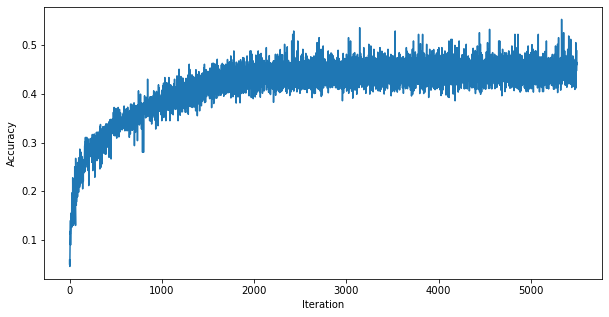

In [16]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

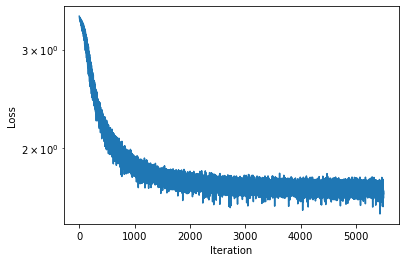

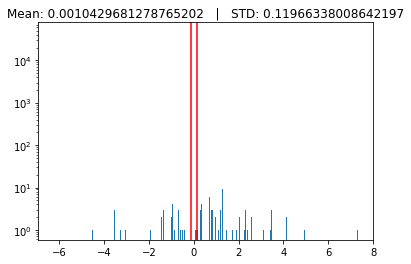

In [17]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

Average height: 7.182926829268292


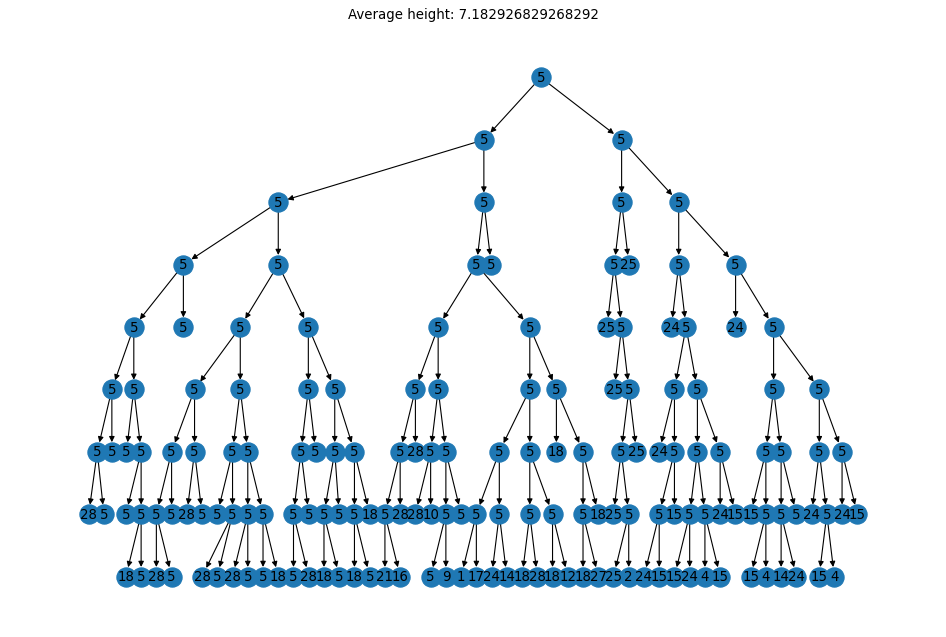

In [18]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [23]:
print(f"Number of patterns: {len(root.get_leaves())}")

Number of patterns: 82


In [24]:
method = 'MLE'

In [25]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

# Tighten boundaries

In [26]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0
comprehensibilities = []
for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    comprehensibilities.append(sum([cond.comprehensibility for cond in conds]))
    
print(f"Average comprehensibility: {np.mean(comprehensibilities)}")
print(f"std comprehensibility: {np.std(comprehensibilities)}")
print(f"var comprehensibility: {np.var(comprehensibilities)}")
print(f"minimum comprehensibility: {np.min(comprehensibilities)}")
print(f"maximum comprehensibility: {np.max(comprehensibilities)}")

332
============== Pattern 1 ==============
============== Pattern 2 ==============
25
============== Pattern 3 ==============
============== Pattern 4 ==============
============== Pattern 5 ==============
111
============== Pattern 6 ==============
============== Pattern 7 ==============
16526
============== Pattern 8 ==============
============== Pattern 9 ==============
============== Pattern 10 ==============
============== Pattern 11 ==============
============== Pattern 12 ==============
============== Pattern 13 ==============
============== Pattern 14 ==============
============== Pattern 15 ==============
============== Pattern 16 ==============
============== Pattern 17 ==============
============== Pattern 18 ==============
============== Pattern 19 ==============
============== Pattern 20 ==============
============== Pattern 21 ==============
============== Pattern 22 ==============
============== Pattern 23 ==============
============== Pattern 24 ==============
========